In [1]:
# Spark imports
import pyspark
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Python imports
import pandas as pd
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.config("SPARK_LOCAL_IP", "192.168.1.2") \
                            .appName("Pre-Preprocess Mission Log") \
                            .master("spark://192.168.1.2:7077") \
                            .config("spark.driver.cores", "2") \
                            .config("spark.driver.memory", "10g") \
                            .config("spark.executor.memory", "12g") \
                            .config("spark.executor.cores", "3") \
                            .config("spark.dynamicAllocation.shuffleTracking.enabled", "true") \
                            .config("spark.dynamicAllocation.enabled", "true") \
                            .config("spark.dynamicAllocation.minExecutors", "5") \
                            .config("spark.dynamicAllocation.maxExecutors", "8") \
                            .config("spark.executor.instances", "5") \
                            .getOrCreate()

# Path to Parquet file, can be modified as needed
data_paths = ["hdfs://192.168.1.2:9000/user/rplenkers-test/correlated_data/11111-CAR7575-202401/final_correlated_dataset_spring-2024/2024-07-08/Full_Dataset_Parquet/2021-12-12 - 2021-12-19/part-00000-729e82b3-3941-4c88-95a5-4c1f6c17151a-c000.snappy.parquet","hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-12 - 2021-12-19/part-00000-7c2e9adb-5430-4792-a42b-10ff5bbd46e8-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-19 - 2021-12-26/part-00000-3f86626a-1225-47f9-a5a2-0170b737e404-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-26 - 2022-01-02/part-00000-b1a9fc13-8068-4a5d-91b2-871438709e81-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-02 - 2022-01-09/part-00000-26e9208e-7819-451b-b23f-2e47f6d1e834-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-09 - 2022-01-16/part-00000-36240b61-b84f-4164-a873-d7973e652780-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-16 - 2022-01-23/part-00000-cbf26680-106d-40e7-8278-60520afdbb0e-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-06 - 2022-02-13/part-00000-df678a79-4a73-452b-8e72-d624b2732f17-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-13 - 2022-02-20/part-00000-1da06990-329c-4e38-913a-0f0aa39b388d-c000.snappy.parquet"
            ]
#Container to hold the processed DataFrames
df_list = []

#Counter variable
j=0;

#Loop through each path, load and process the data
for path in data_paths:
    # Load each dataset
    df = spark.read.parquet(path)
    
    # Select relevant columns
    df = df.select("ts", "duration", "orig_bytes", "resp_bytes", "orig_ip_bytes", "resp_ip_bytes", "label_tactic")
    
    #Count the number of nulls in the 'label_tactic' column before filling
    null_count_before = df.filter(F.col("label_tactic").isNull()).count()
    print(f"NUmber of null values in 'label_tactic' before fillna: {null_count_before}")
    
    # Handle missing values
    df = df.fillna({
        "duration": 0,
        "orig_bytes": 0,
        "resp_bytes": 0,
        "orig_ip_bytes": 0,
        "resp_ip_bytes": 0,
        "label_tactic" : "none" #Default to 'none'
    })

    #Show the unique count for each tactic type before converting to binary
    print(f"Dataset {j+1}: Unique count for each 'label_tactic' value before conversion")
    unique_tactic_counts = df.groupBy("label_tactic").count().orderBy(F.desc("count"))
    unique_tactic_counts.show(truncate=False)                                                                             
    
    #Convert 'Label_tactic' to a binary: 'none' -> 0, anything else -> 1
    df = df.withColumn("label_tactic_binary", F.when(F.col("label_tactic") == "none", 0).otherwise(1))

    #Show the binary count after conversion
    
    print(f"Dataset {j+1}: Count for binary 'label_tactic_binary' after conversion")
    binary_counts = df.groupBy("label_tactic_binary").count().orderBy(F.desc("label_tactic_binary"))
    binary_counts.show(truncate=False)
    j+=1;
    
    # Convert 'ts' to a timestamp
    df = df.withColumn("ts", F.from_unixtime("ts").cast("timestamp"))
    
    # Define window size and stride
    window_size = "10 minutes" #Changed from 15 minutes
    stride = "0 minutes" #Remove overlap to test for artificial seasonality
    
    # Aggregate data within overlapping time windows
    #df_agg = df.groupBy(F.window("ts", window_size, stride)) \
    df_agg = df.groupBy(F.window("ts", window_size)) \
        .agg(
            F.sum("orig_bytes").alias("sum_orig_bytes"),
            F.sum("resp_bytes").alias("sum_resp_bytes"),
            F.sum("orig_ip_bytes").alias("sum_orig_ip_bytes"),
            F.sum("resp_ip_bytes").alias("sum_resp_ip_bytes"),
            F.count("*").alias("connection_count"),
            F.max("label_tactic_binary").alias("label_tactic_binary_agg") 
        )

    # Flatten the window structure
    df_agg_flat = df_agg.select(
        F.col("window.start").alias("window_start"),
        F.col("window.end").alias("window_end"),
        "sum_orig_bytes",
        "sum_resp_bytes",
        "sum_orig_ip_bytes",
        "sum_resp_ip_bytes",
        "connection_count",
        "label_tactic_binary_agg"
    )

    # Sort by window start time
    df_agg_sorted = df_agg_flat.orderBy("window_start")
    
    # Convert Spark DataFrame to Pandas for further analysis
    df_pandas_sorted = df_agg_sorted.toPandas()

    #Print the number of rows
    print(f" DataFrame for: {path} has total rows: {len(df_pandas_sorted)}")

    #Display column names of the dataframe
    print(df_pandas_sorted.columns)
    
    #Add to DataFrame List
    df_list.append(df_pandas_sorted)

#Split and preprocess datasets
df_train_list = []
df_test_list = []

for i, df_pandas_sorted in enumerate(df_list):
    #Split into train and test sets
    train_ratio = 0.7 #Change ratio as needed
    split_index = int(len(df_pandas_sorted) * train_ratio)
    df_train = df_pandas_sorted.iloc[:split_index].copy()
    df_test = df_pandas_sorted.iloc[split_index:].copy()

    #Nomarlize using the maximum value from the training set
    scaling_factor = df_train["sum_orig_bytes"].max()

    #Add check to ensure scaling factor does not cause a divide by zero
    if scaling_factor ==0:
        scaling_factor =1
    
    df_train["sum_orig_bytes_norm"] = df_train["sum_orig_bytes"] / scaling_factor
    df_train["sum_orig_bytes_log"] = np.log1p(df_train["sum_orig_bytes_norm"])
    df_test["sum_orig_bytes_norm"] = df_test["sum_orig_bytes"] / scaling_factor
    df_test["sum_orig_bytes_log"] = np.log1p(df_test["sum_orig_bytes_norm"])

    #Append to lists
    df_train_list.append(df_train)
    df_test_list.append(df_test)

    #Print the sizes of the new sets
    print(f"Dataset {i+1}:")
    print(f" Training set size: {len(df_train)} rows")
    print(f" Testing set size: {len(df_test)} rows")
    print("-" * 40)
    
    # Indicate the dataframe is finished loading
    print(f"Finished loading dataset {i+1}.")

24/12/01 09:28:51 WARN Utils: Your hostname, ubuntu-virtual-machine resolves to a loopback address: 127.0.1.1; using 192.168.1.145 instead (on interface ens33)
24/12/01 09:28:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/01 09:28:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


NUmber of null values in 'label_tactic' before fillna: 0
Dataset 1: Unique count for each 'label_tactic' value before conversion


+------------+-----+
|label_tactic|count|
+------------+-----+
|none        |218  |
+------------+-----+

Dataset 1: Count for binary 'label_tactic_binary' after conversion


+-------------------+-----+
|label_tactic_binary|count|
+-------------------+-----+
|0                  |218  |
+-------------------+-----+



 DataFrame for: hdfs://192.168.1.2:9000/user/rplenkers-test/correlated_data/11111-CAR7575-202401/final_correlated_dataset_spring-2024/2024-07-08/Full_Dataset_Parquet/2021-12-12 - 2021-12-19/part-00000-729e82b3-3941-4c88-95a5-4c1f6c17151a-c000.snappy.parquet has total rows: 141
Index(['window_start', 'window_end', 'sum_orig_bytes', 'sum_resp_bytes',
       'sum_orig_ip_bytes', 'sum_resp_ip_bytes', 'connection_count',
       'label_tactic_binary_agg'],
      dtype='object')


NUmber of null values in 'label_tactic' before fillna: 0
Dataset 2: Unique count for each 'label_tactic' value before conversion


+------------+------+
|label_tactic|count |
+------------+------+
|none        |428724|
+------------+------+

Dataset 2: Count for binary 'label_tactic_binary' after conversion
+-------------------+------+
|label_tactic_binary|count |
+-------------------+------+
|0                  |428724|
+-------------------+------+



 DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-12 - 2021-12-19/part-00000-7c2e9adb-5430-4792-a42b-10ff5bbd46e8-c000.snappy.parquet has total rows: 246
Index(['window_start', 'window_end', 'sum_orig_bytes', 'sum_resp_bytes',
       'sum_orig_ip_bytes', 'sum_resp_ip_bytes', 'connection_count',
       'label_tactic_binary_agg'],
      dtype='object')
NUmber of null values in 'label_tactic' before fillna: 0
Dataset 3: Unique count for each 'label_tactic' value before conversion


+------------+-------+
|label_tactic|count  |
+------------+-------+
|none        |1757069|
+------------+-------+

Dataset 3: Count for binary 'label_tactic_binary' after conversion
+-------------------+-------+
|label_tactic_binary|count  |
+-------------------+-------+
|0                  |1757069|
+-------------------+-------+



 DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-19 - 2021-12-26/part-00000-3f86626a-1225-47f9-a5a2-0170b737e404-c000.snappy.parquet has total rows: 1008
Index(['window_start', 'window_end', 'sum_orig_bytes', 'sum_resp_bytes',
       'sum_orig_ip_bytes', 'sum_resp_ip_bytes', 'connection_count',
       'label_tactic_binary_agg'],
      dtype='object')
NUmber of null values in 'label_tactic' before fillna: 0
Dataset 4: Unique count for each 'label_tactic' value before conversion
+------------+-------+
|label_tactic|count  |
+------------+-------+
|none        |1757998|
+------------+-------+

Dataset 4: Count for binary 'label_tactic_binary' after conversion
+-------------------+-------+
|label_tactic_binary|count  |
+-------------------+-------+
|0                  |1757998|
+-------------------+-------+



 DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-26 - 2022-01-02/part-00000-b1a9fc13-8068-4a5d-91b2-871438709e81-c000.snappy.parquet has total rows: 1008
Index(['window_start', 'window_end', 'sum_orig_bytes', 'sum_resp_bytes',
       'sum_orig_ip_bytes', 'sum_resp_ip_bytes', 'connection_count',
       'label_tactic_binary_agg'],
      dtype='object')
NUmber of null values in 'label_tactic' before fillna: 0
Dataset 5: Unique count for each 'label_tactic' value before conversion
+------------+-------+
|label_tactic|count  |
+------------+-------+
|none        |2403853|
+------------+-------+

Dataset 5: Count for binary 'label_tactic_binary' after conversion
+-------------------+-------+
|label_tactic_binary|count  |
+-------------------+-------+
|0                  |2403853|
+-------------------+-------+



 DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-02 - 2022-01-09/part-00000-26e9208e-7819-451b-b23f-2e47f6d1e834-c000.snappy.parquet has total rows: 1003
Index(['window_start', 'window_end', 'sum_orig_bytes', 'sum_resp_bytes',
       'sum_orig_ip_bytes', 'sum_resp_ip_bytes', 'connection_count',
       'label_tactic_binary_agg'],
      dtype='object')
NUmber of null values in 'label_tactic' before fillna: 0
Dataset 6: Unique count for each 'label_tactic' value before conversion
+------------+-------+
|label_tactic|count  |
+------------+-------+
|none        |2579855|
+------------+-------+

Dataset 6: Count for binary 'label_tactic_binary' after conversion
+-------------------+-------+
|label_tactic_binary|count  |
+-------------------+-------+
|0                  |2579855|
+-------------------+-------+



 DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-09 - 2022-01-16/part-00000-36240b61-b84f-4164-a873-d7973e652780-c000.snappy.parquet has total rows: 1002
Index(['window_start', 'window_end', 'sum_orig_bytes', 'sum_resp_bytes',
       'sum_orig_ip_bytes', 'sum_resp_ip_bytes', 'connection_count',
       'label_tactic_binary_agg'],
      dtype='object')
NUmber of null values in 'label_tactic' before fillna: 0
Dataset 7: Unique count for each 'label_tactic' value before conversion
+------------+------+
|label_tactic|count |
+------------+------+
|none        |354100|
+------------+------+

Dataset 7: Count for binary 'label_tactic_binary' after conversion
+-------------------+------+
|label_tactic_binary|count |
+-------------------+------+
|0                  |354100|
+-------------------+------+



 DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-16 - 2022-01-23/part-00000-cbf26680-106d-40e7-8278-60520afdbb0e-c000.snappy.parquet has total rows: 138
Index(['window_start', 'window_end', 'sum_orig_bytes', 'sum_resp_bytes',
       'sum_orig_ip_bytes', 'sum_resp_ip_bytes', 'connection_count',
       'label_tactic_binary_agg'],
      dtype='object')
NUmber of null values in 'label_tactic' before fillna: 0
Dataset 8: Unique count for each 'label_tactic' value before conversion


+--------------+-------+
|label_tactic  |count  |
+--------------+-------+
|Reconnaissance|9278720|
|Discovery     |2086   |
+--------------+-------+

Dataset 8: Count for binary 'label_tactic_binary' after conversion


+-------------------+-------+
|label_tactic_binary|count  |
+-------------------+-------+
|1                  |9280806|
+-------------------+-------+



 DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-06 - 2022-02-13/part-00000-df678a79-4a73-452b-8e72-d624b2732f17-c000.snappy.parquet has total rows: 31
Index(['window_start', 'window_end', 'sum_orig_bytes', 'sum_resp_bytes',
       'sum_orig_ip_bytes', 'sum_resp_ip_bytes', 'connection_count',
       'label_tactic_binary_agg'],
      dtype='object')
NUmber of null values in 'label_tactic' before fillna: 0
Dataset 9: Unique count for each 'label_tactic' value before conversion
+--------------------+-----+
|label_tactic        |count|
+--------------------+-----+
|Credential Access   |31   |
|Privilege Escalation|13   |
|Exfiltration        |7    |
|Lateral Movement    |4    |
|Resource Development|3    |
|Reconnaissance      |2    |
|Persistence         |1    |
|Initial Access      |1    |
|Defense Evasion     |1    |
+--------------------+-----+

Dataset 9: Count for binary 'label_tactic_binary' after conversion
+-------------------+-----+
|label_t

Bar Chart for Binary Attack Counts:


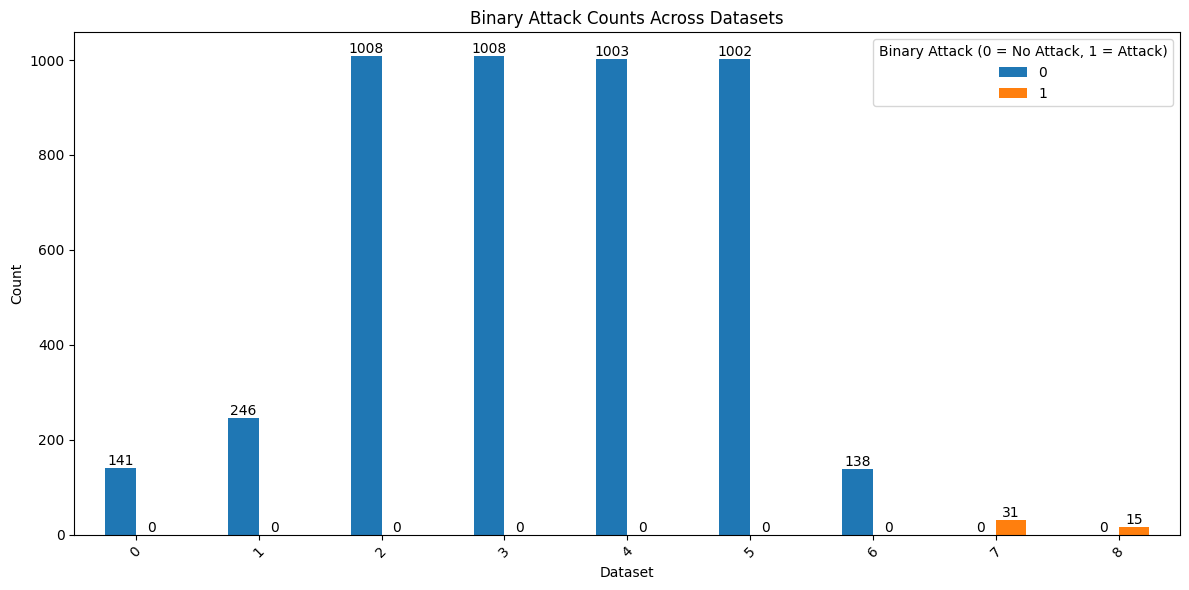

In [2]:
# Bar chart for binary attack counts across datasets with labels
def plot_binary_attack_counts_with_labels(df_list):
    attack_counts = []
    dataset_names = []

    for i, df in enumerate(df_list):
        # Count binary attack indicators (0 = no attack, 1 = attack)
        counts = df['label_tactic_binary_agg'].value_counts().sort_index()
        attack_counts.append(counts)
        dataset_names.append(f"Dataset {i+1}")

    # Combine counts into a DataFrame for plotting
    attack_df = pd.DataFrame(attack_counts, index=dataset_names).fillna(0)

    # Create bar chart
    ax = attack_df.plot(
        kind='bar',
        figsize=(12, 6),
        title="Binary Attack Counts Across Datasets",
        ylabel="Count",
        xlabel="Dataset",
        xticks=range(len(dataset_names)),
        rot=45,
    )

    # Add labels to each bar
    for p in ax.patches:
        height = int(p.get_height())
        ax.annotate(f'{height}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10)

    plt.legend(title="Binary Attack (0 = No Attack, 1 = Attack)")
    plt.tight_layout()
    plt.show()

# Call the updated bar chart function
print("Bar Chart for Binary Attack Counts:")
plot_binary_attack_counts_with_labels(df_list)

Line Graphs for Binary Label Tactic Over Time:


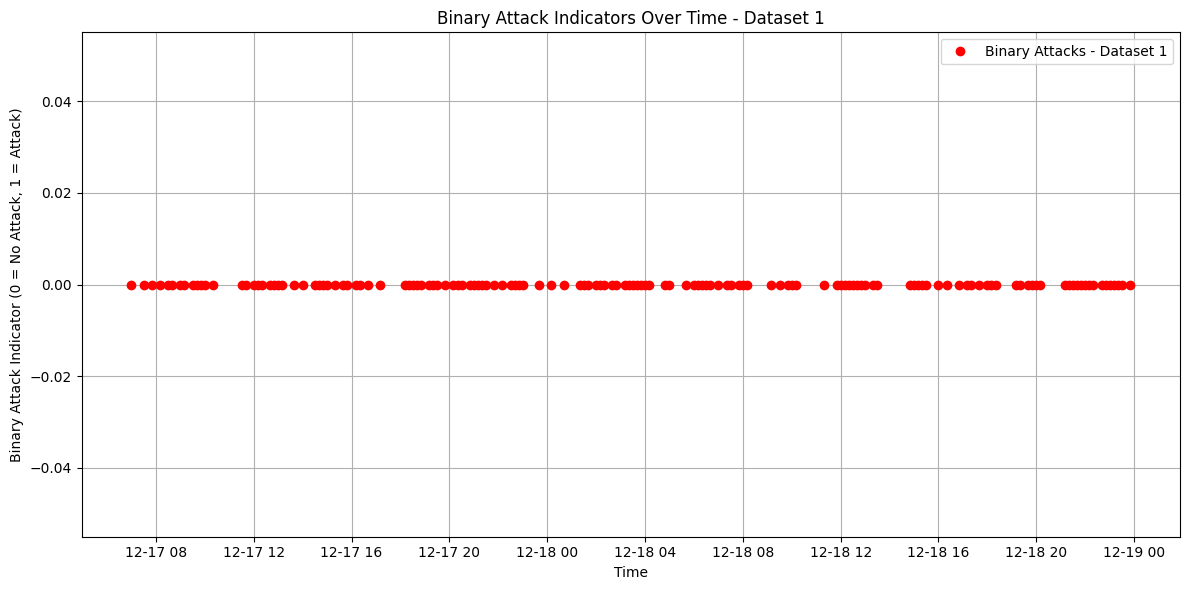

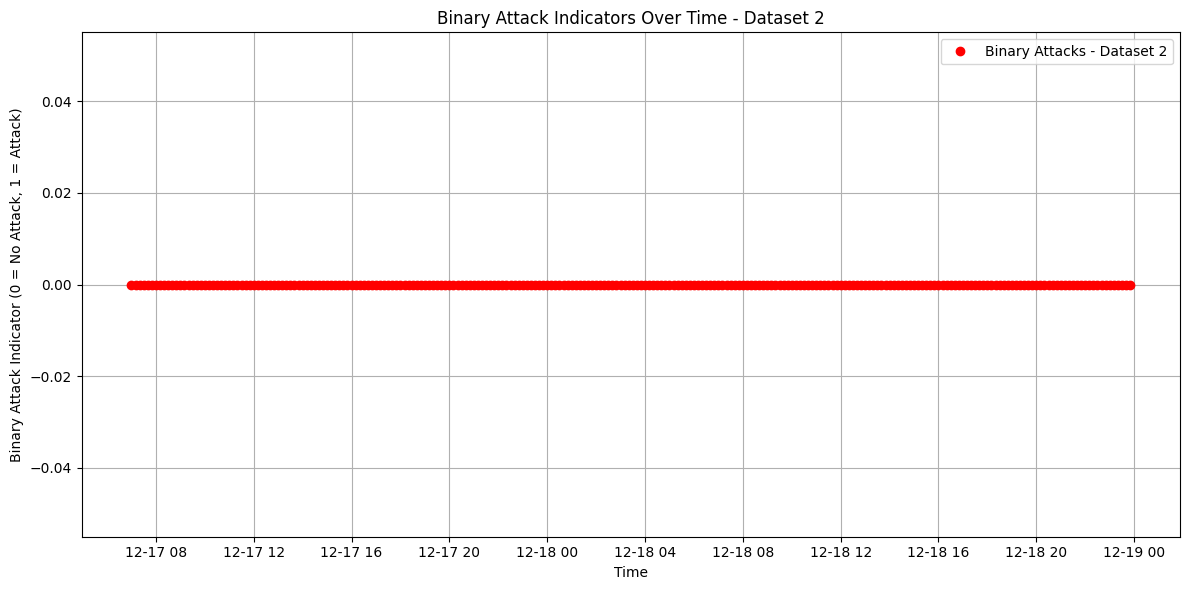

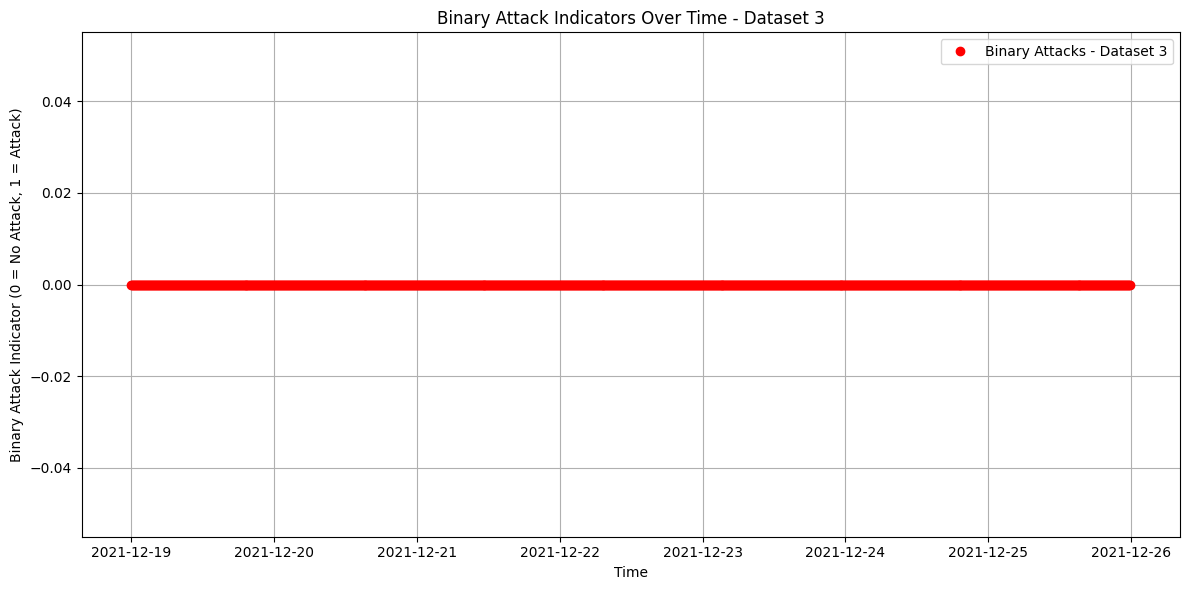

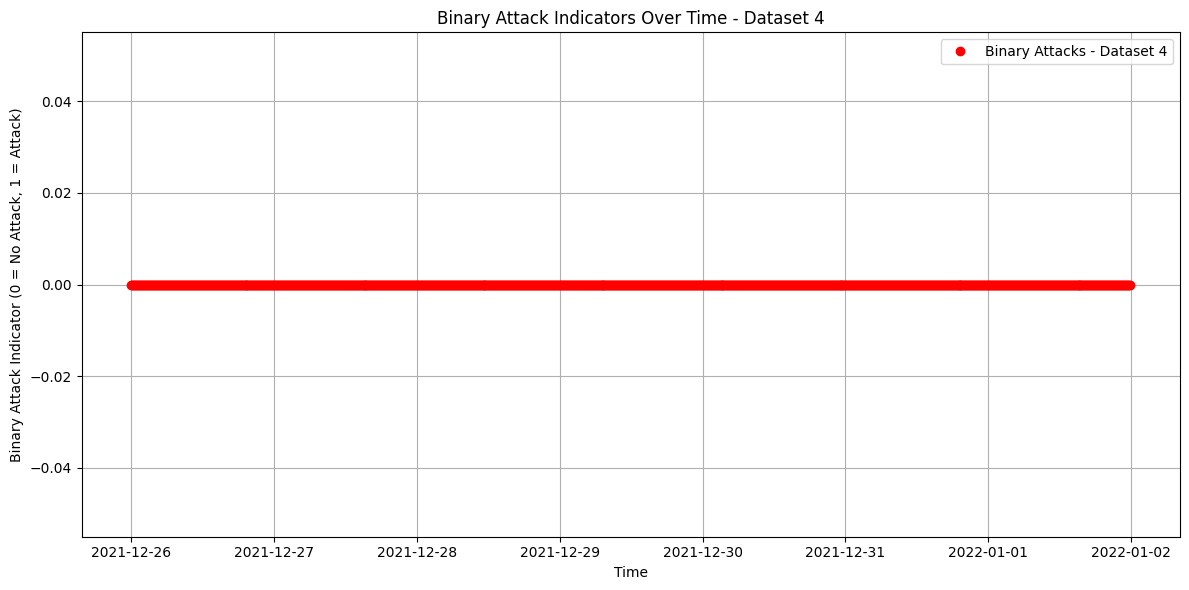

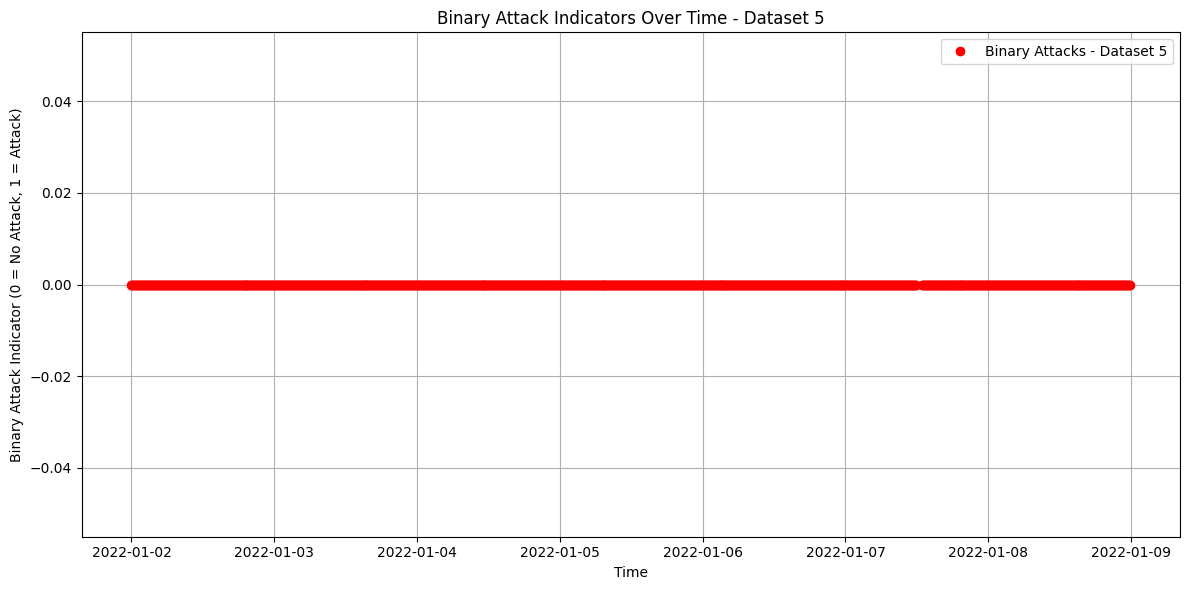

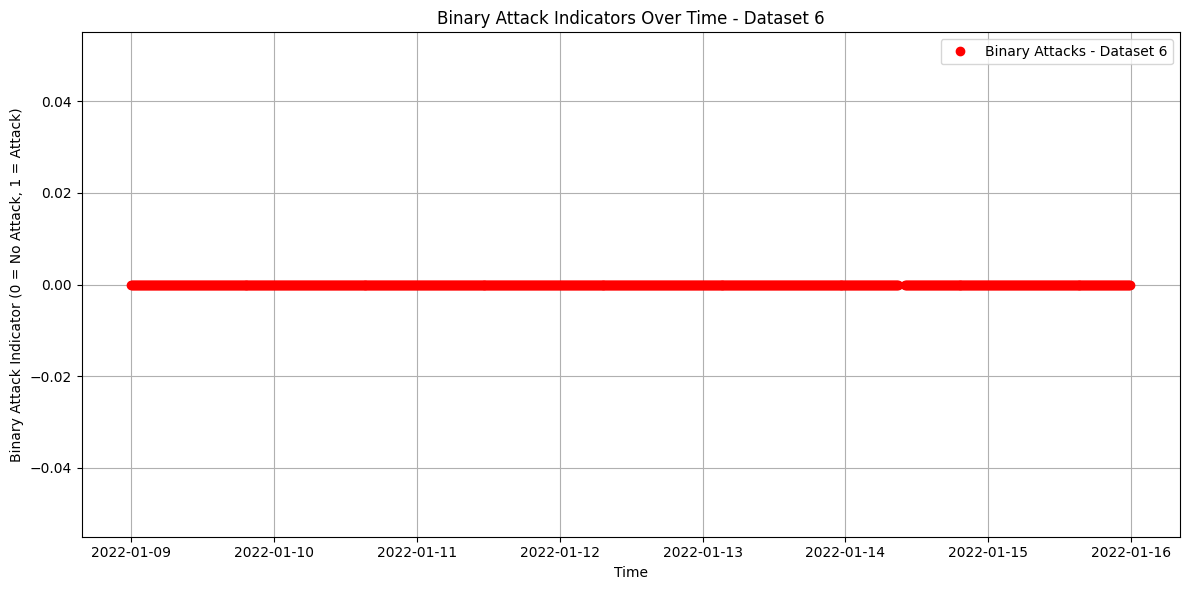

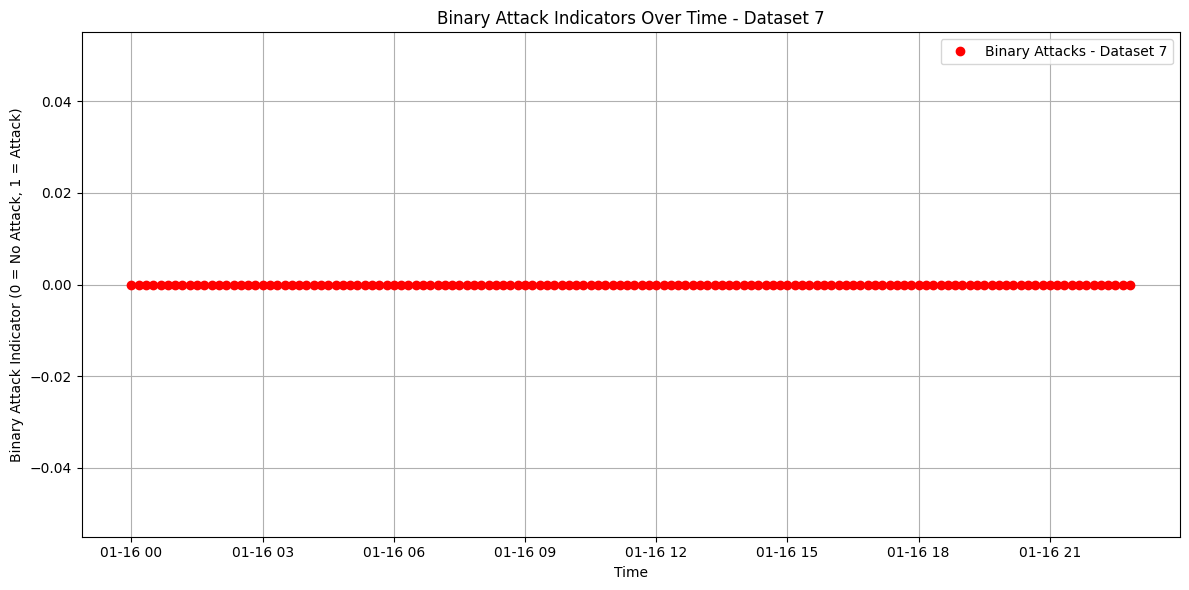

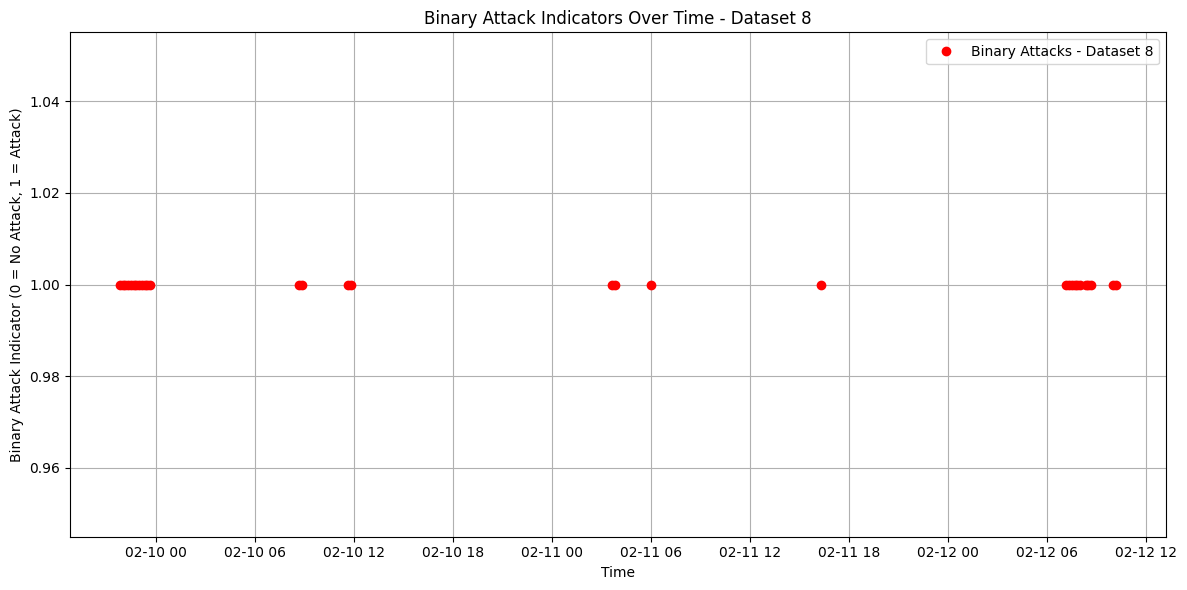

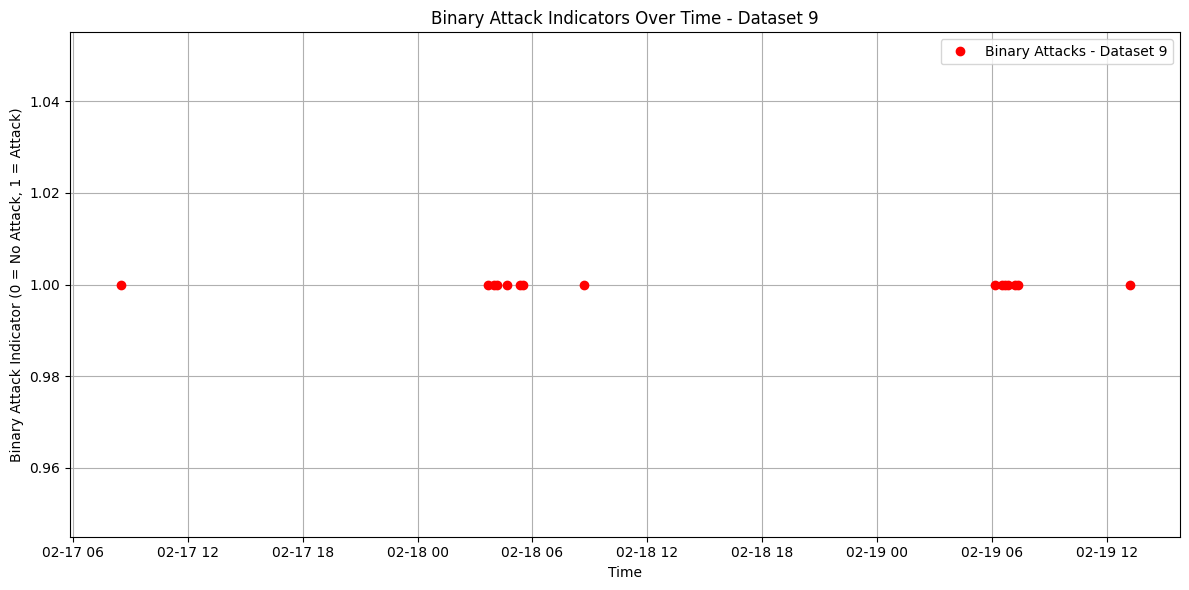

In [3]:
def plot_binary_label_tactic_over_time(df_list):
    for i, df in enumerate(df_list):
        plt.figure(figsize=(12, 6))
       
        # Plot binary attack values over time
        plt.plot(
            df['window_start'],
            df['label_tactic_binary_agg'],
            label=f"Binary Attacks - Dataset {i+1}",
            color='red',
            marker='o',
            linestyle='None'  # Use points to clearly show individual values
        )
       
        plt.title(f"Binary Attack Indicators Over Time - Dataset {i+1}")
        plt.xlabel("Time")
        plt.ylabel("Binary Attack Indicator (0 = No Attack, 1 = Attack)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

#Plot the binary label tactic over time for each dataset
print("Line Graphs for Binary Label Tactic Over Time:")
plot_binary_label_tactic_over_time(df_list)

Train ARIMA Model

Visualize DataFrame that is Used for Training

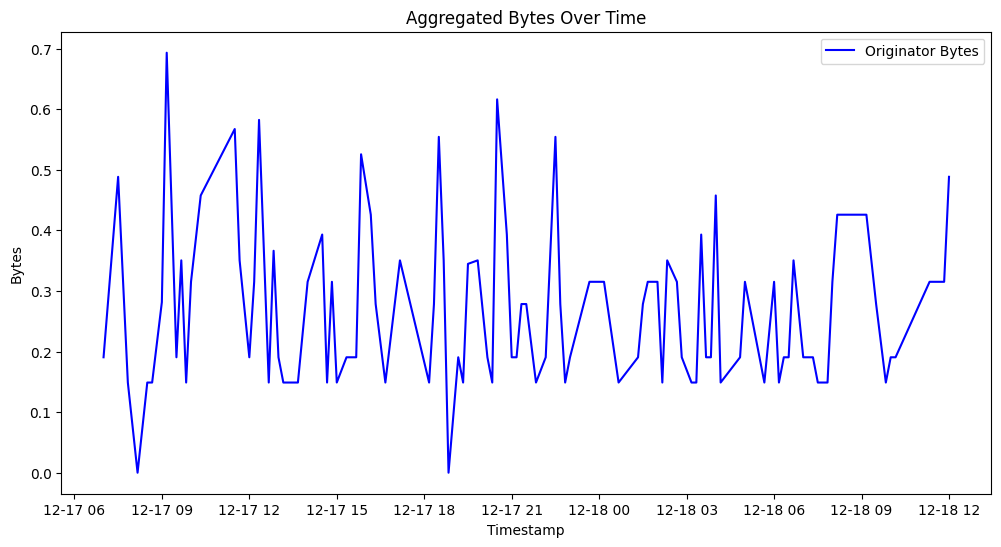

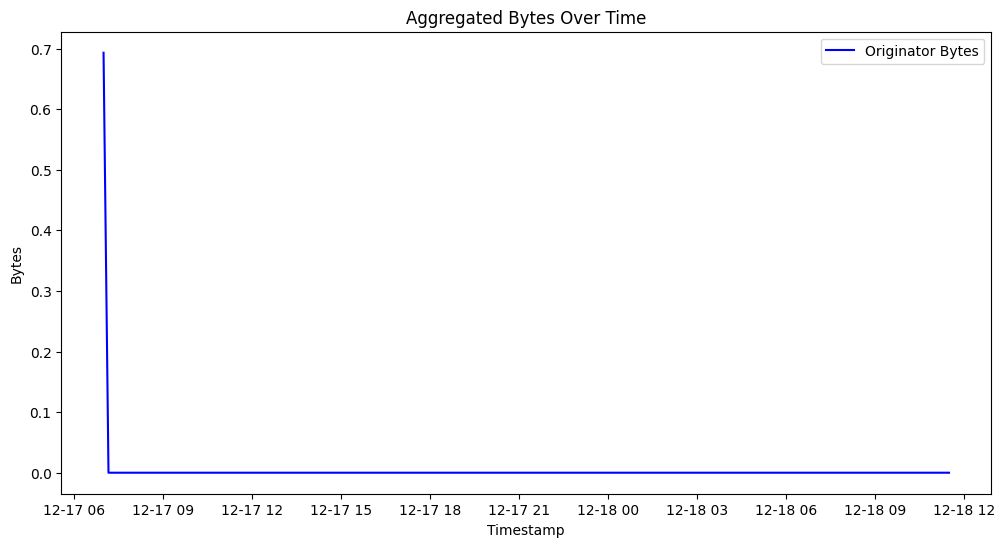

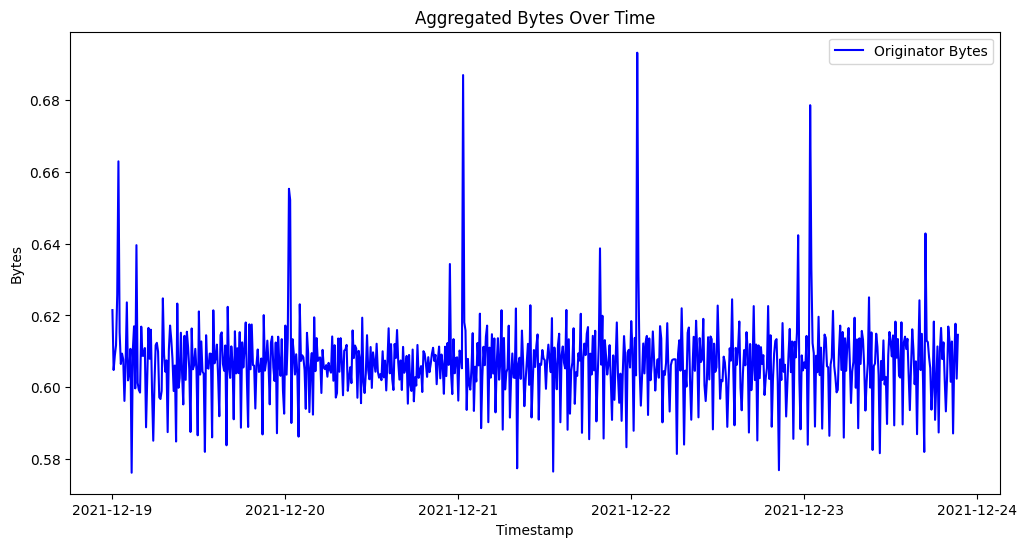

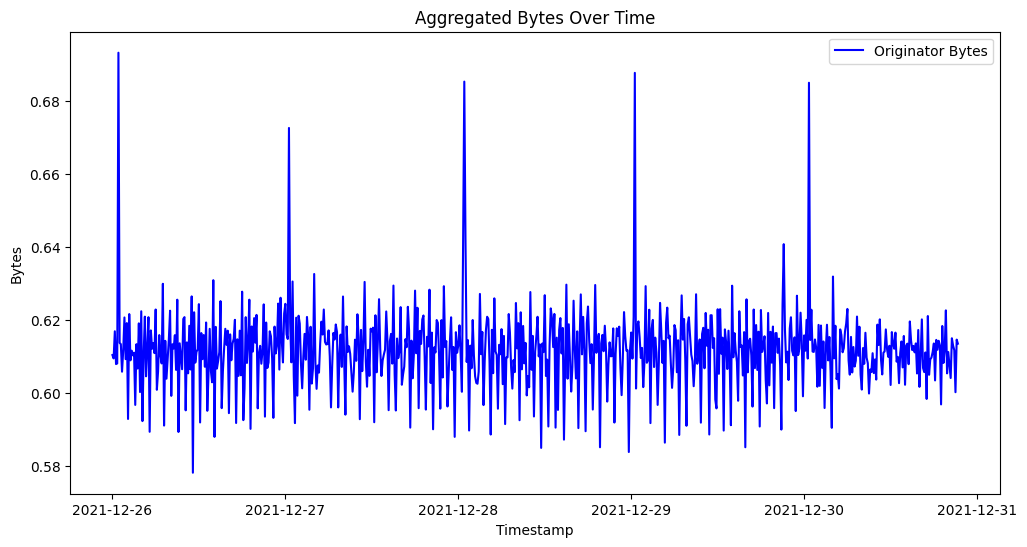

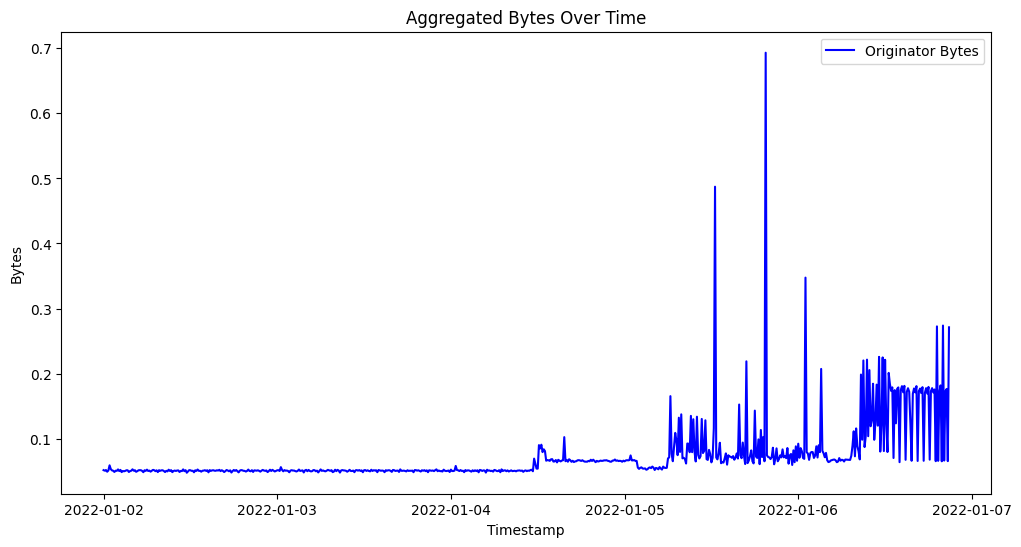

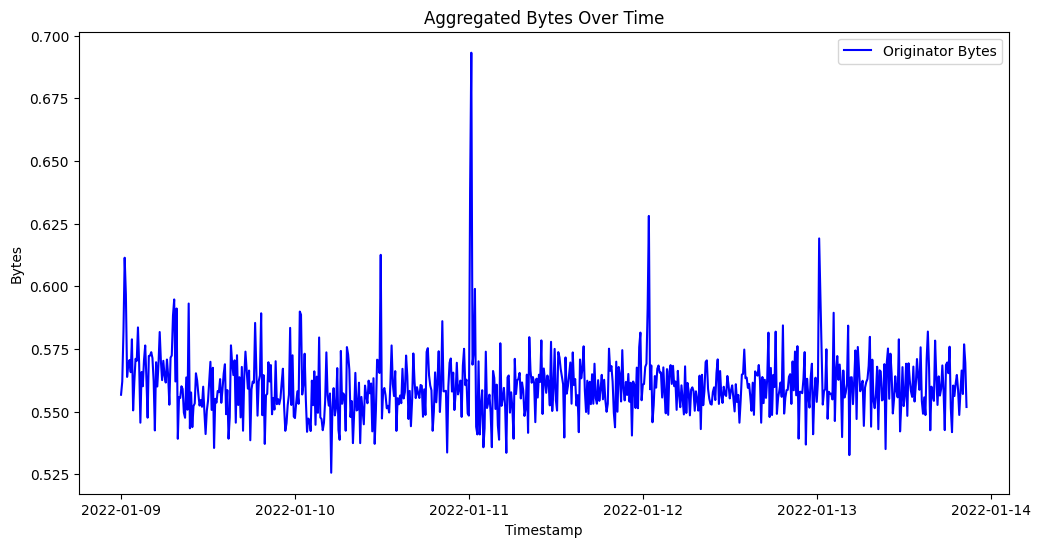

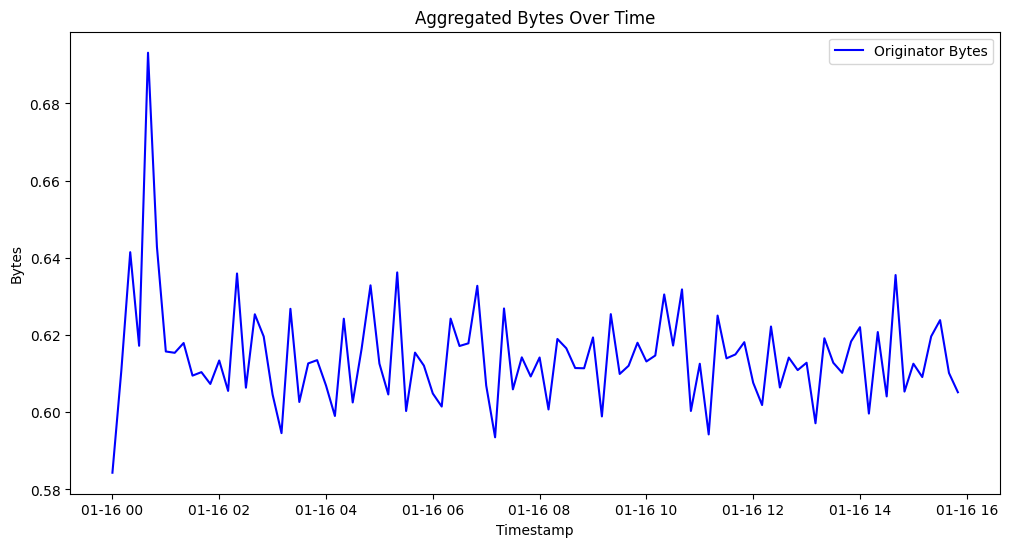

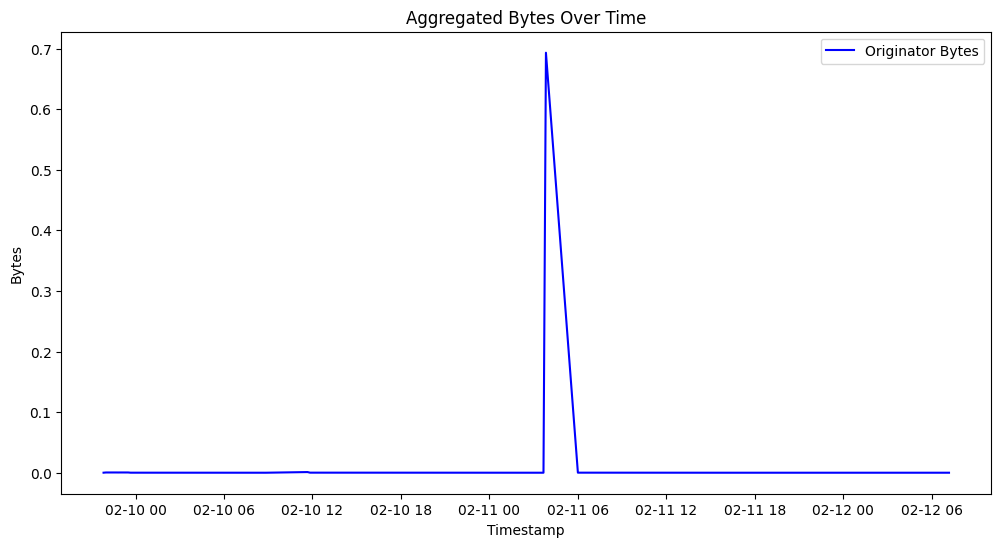

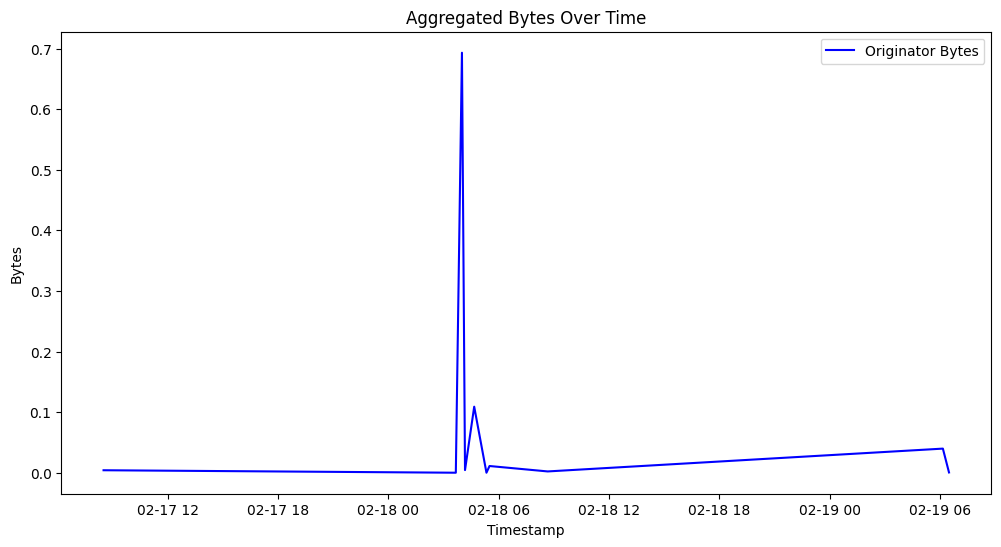

In [4]:
import matplotlib.pyplot as plt
for i, df_train in enumerate(df_train_list):

    #Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(df_train['window_start'], df_train['sum_orig_bytes_log'], label = 'Originator Bytes', color = 'blue')
    #plt.plot(df_train['window_start'], df_train['sum_resp_bytes_log'], label = 'Response Bytes', color = 'red')
    
    #Titles and Labels
    plt.xlabel('Timestamp')
    plt.ylabel('Bytes')
    plt.title('Aggregated Bytes Over Time')
    plt.legend()
    plt.show()

Stationarity Test

In [5]:
#Check for Stationarity Using Augmented Dickey-Fuller (ADF) Test
#Consider p-value threshold of 0.05
from statsmodels.tsa.stattools import adfuller
for i, df_train in enumerate(df_train_list):   
    #Perform ADF test on the 'sum_orig_bytes' time series
    result = adfuller(df_train['sum_orig_bytes_log'].dropna())
    
    #Extract and print test statistics
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values: ')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    #Interpret the result
    if result[1] < 0.05:
        print(f"The time series for dataset {i+1} is stationary (reject H0)")
    else:
        print(f"The time series for dataset {i+1} is non-stationary (fail to reject H0)")

ADF Statistic: -8.224585
p-value: 0.000000
Critical Values: 
	1%: -3.500
	5%: -2.892
	10%: -2.583
The time series for dataset 1 is stationary (reject H0)
ADF Statistic: -5.242633
p-value: 0.000007
Critical Values: 
	1%: -3.472
	5%: -2.880
	10%: -2.576
The time series for dataset 2 is stationary (reject H0)
ADF Statistic: -6.508284
p-value: 0.000000
Critical Values: 
	1%: -3.440
	5%: -2.866
	10%: -2.569
The time series for dataset 3 is stationary (reject H0)
ADF Statistic: -5.935542
p-value: 0.000000
Critical Values: 
	1%: -3.440
	5%: -2.866
	10%: -2.569
The time series for dataset 4 is stationary (reject H0)
ADF Statistic: -0.887160
p-value: 0.792171
Critical Values: 
	1%: -3.440
	5%: -2.866
	10%: -2.569
The time series for dataset 5 is non-stationary (fail to reject H0)
ADF Statistic: -5.479534
p-value: 0.000002
Critical Values: 
	1%: -3.440
	5%: -2.866
	10%: -2.569
The time series for dataset 6 is stationary (reject H0)
ADF Statistic: -3.017700
p-value: 0.033274
Critical Values: 
	1%

Plot of ACF and PACF from Stationary Series

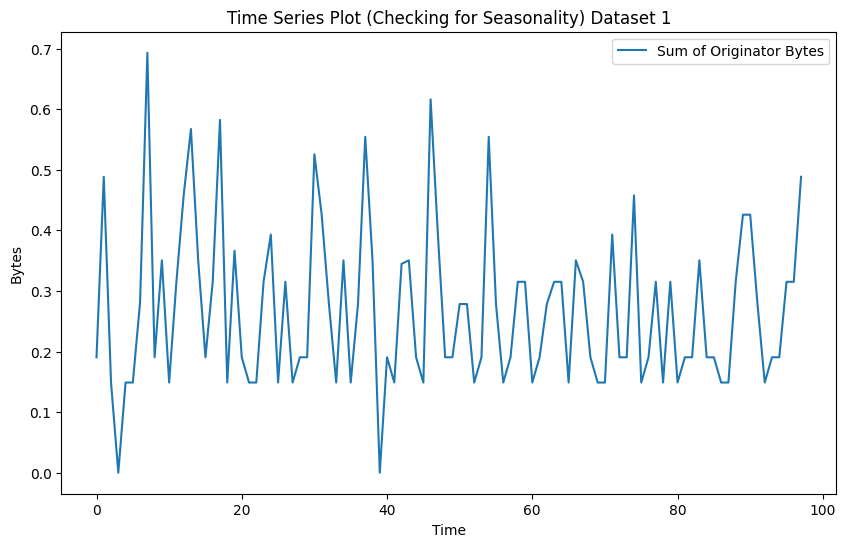

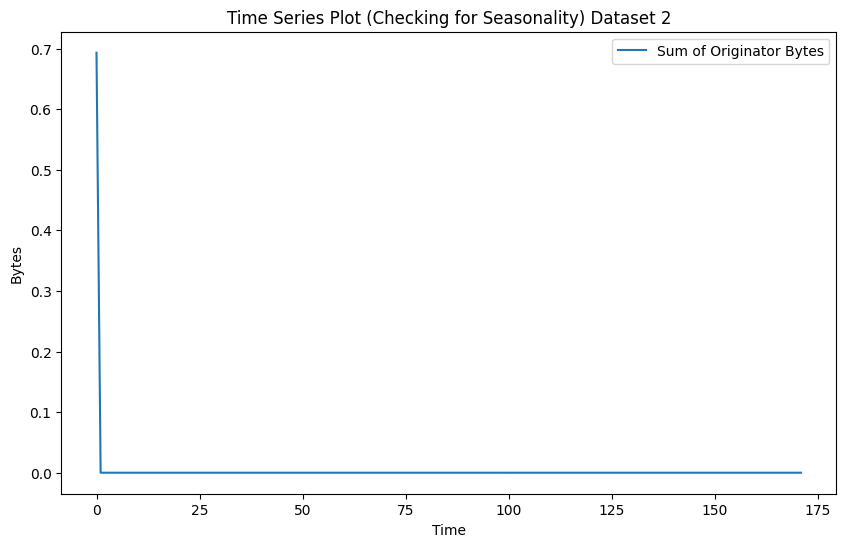

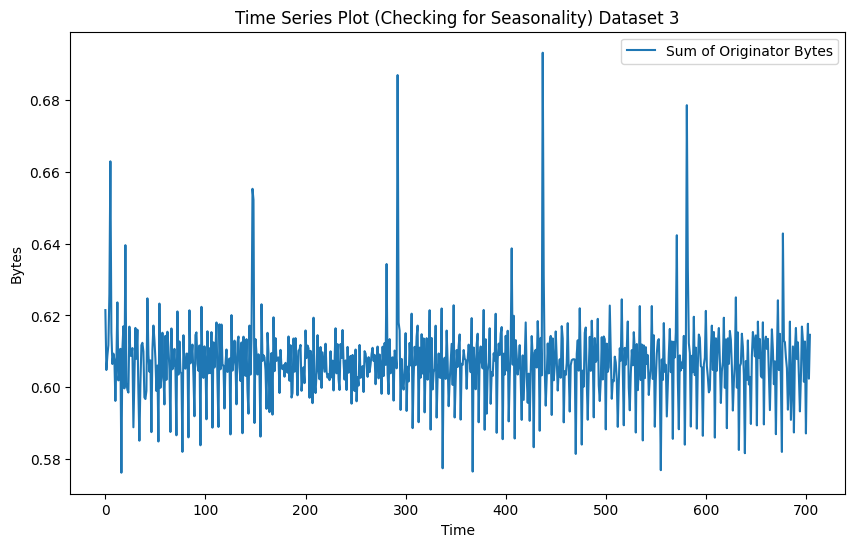

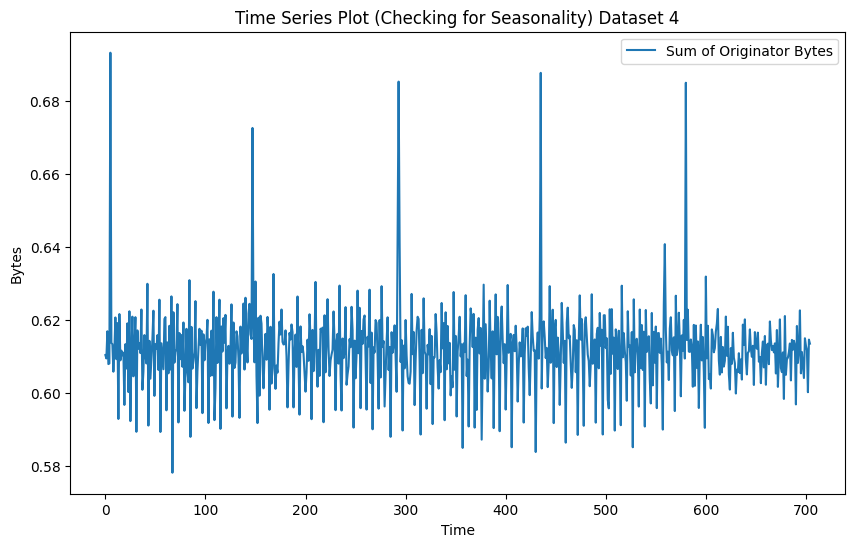

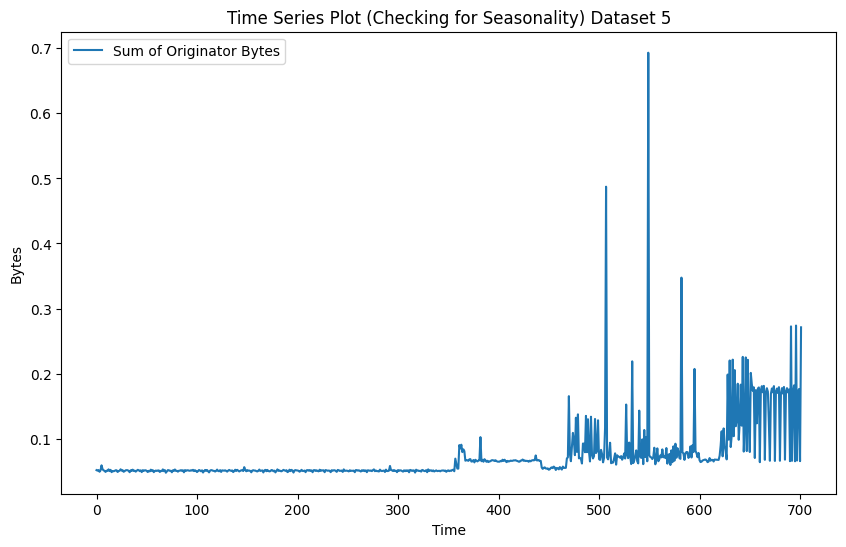

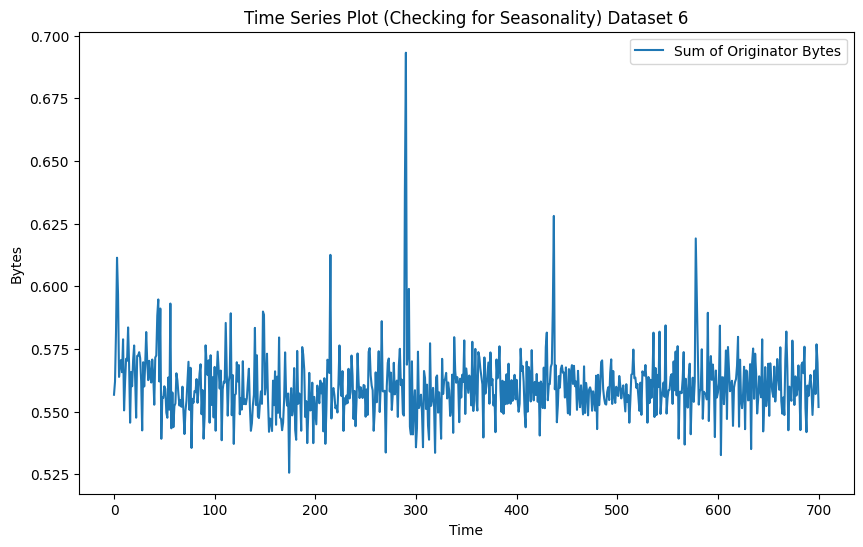

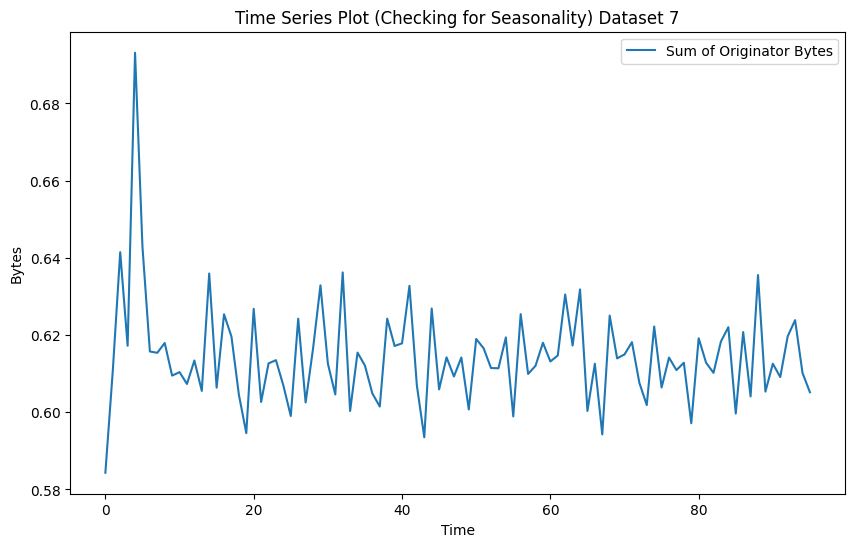

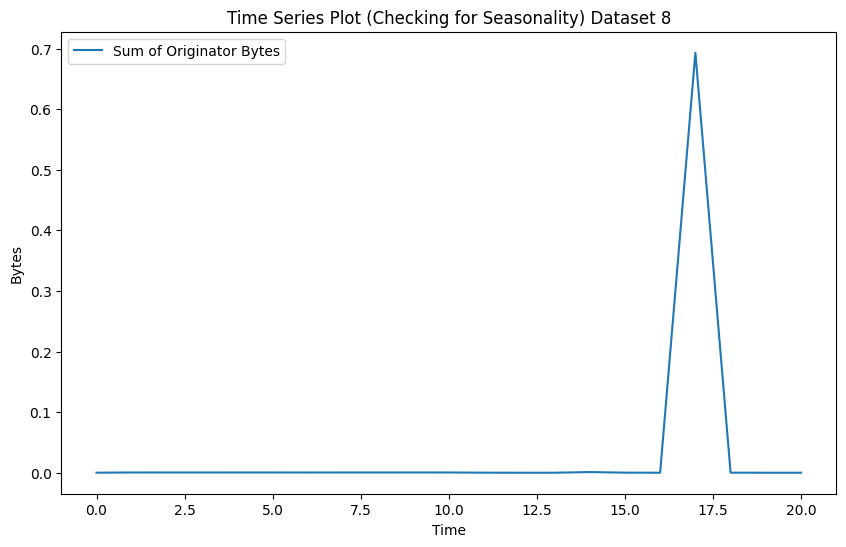

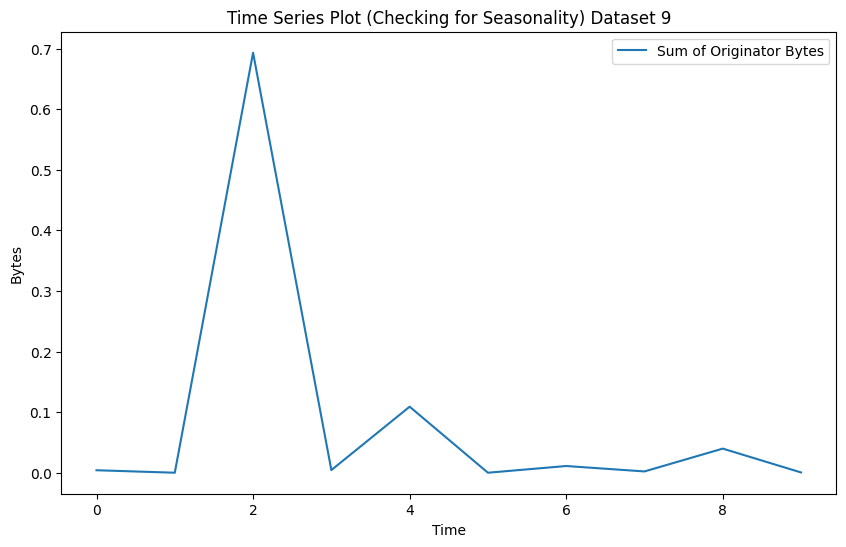

In [6]:
#Check for seasonality
import matplotlib.pyplot as plt
for i, df_train in enumerate(df_train_list):
    #Plot the original time series
    plt.figure(figsize=(10,6))
    plt.plot(df_train['sum_orig_bytes_log'], label='Sum of Originator Bytes')
    plt.title(f'Time Series Plot (Checking for Seasonality) Dataset {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Bytes')
    plt.legend()
    plt.show()

The time series for dataset 1 shows evidence of seasonality with a period of 2.


<Figure size 1000x600 with 0 Axes>

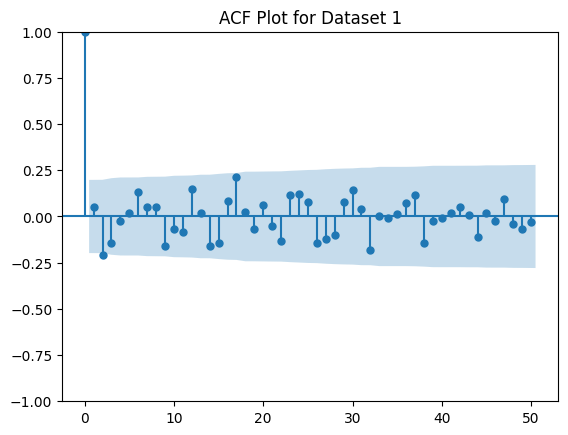

The time series for dataset 2 does not show significant evidence of seasonality.


<Figure size 1000x600 with 0 Axes>

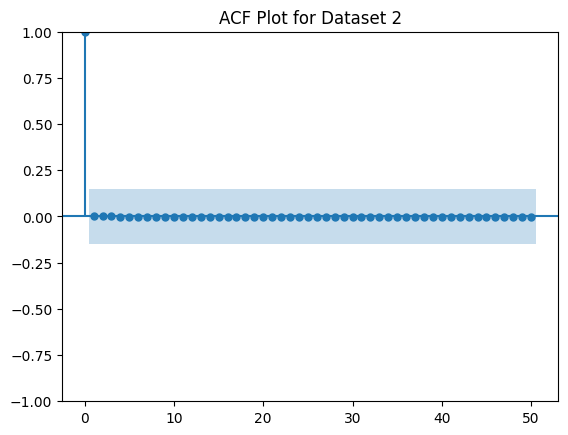

The time series for dataset 3 shows evidence of seasonality with a period of 3.


<Figure size 1000x600 with 0 Axes>

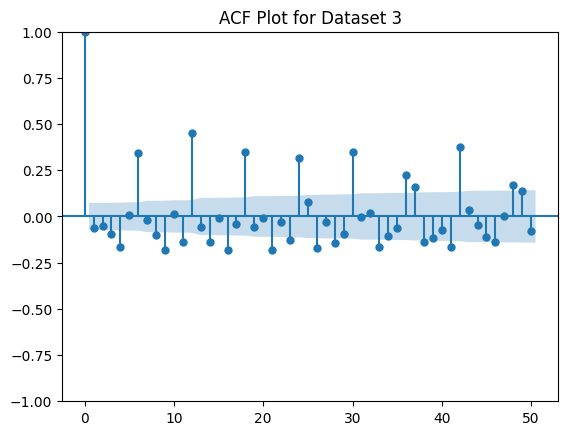

The time series for dataset 4 shows evidence of seasonality with a period of 3.


<Figure size 1000x600 with 0 Axes>

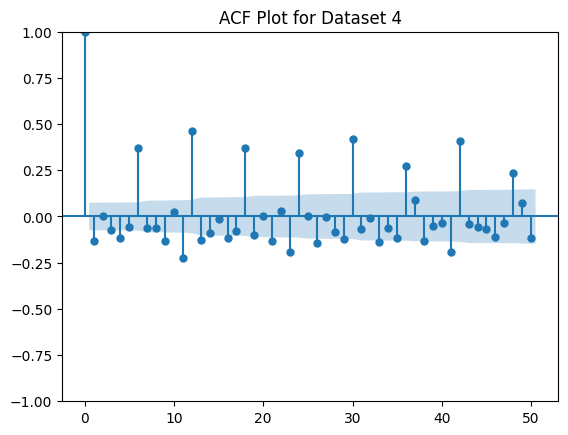

The time series for dataset 5 does not show significant evidence of seasonality.


<Figure size 1000x600 with 0 Axes>

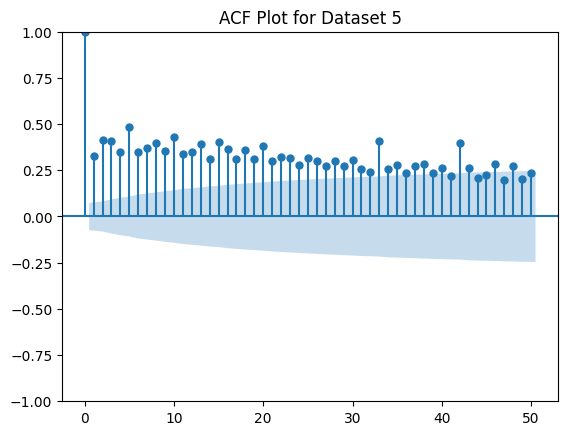

The time series for dataset 6 shows evidence of seasonality with a period of 2.


<Figure size 1000x600 with 0 Axes>

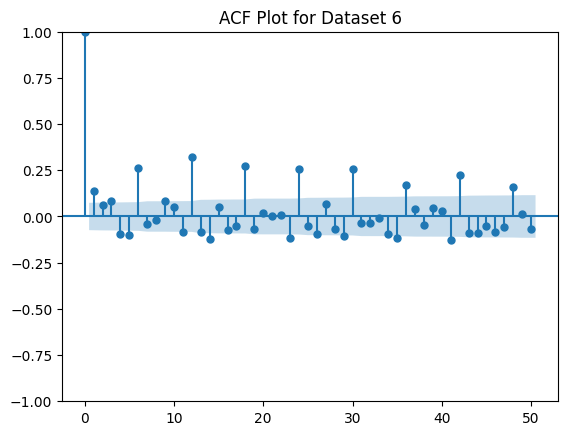

The time series for dataset 7 shows evidence of seasonality with a period of 5.


<Figure size 1000x600 with 0 Axes>

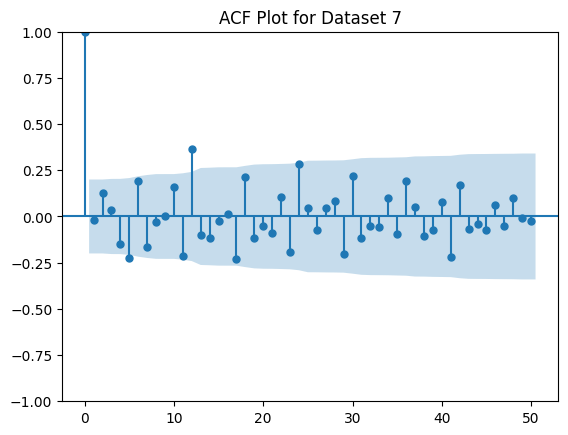

The time series for dataset 8 does not show significant evidence of seasonality.


<Figure size 1000x600 with 0 Axes>

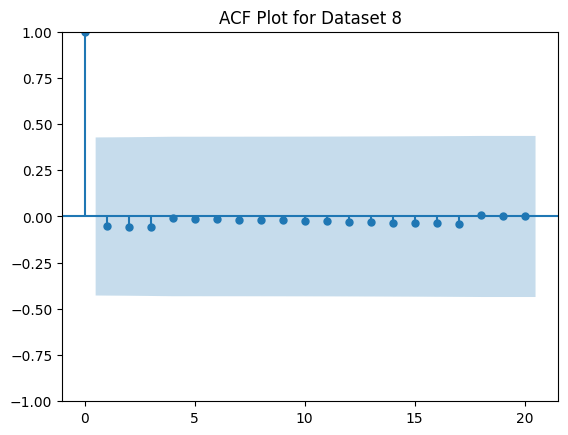

The time series for dataset 9 does not show significant evidence of seasonality.


<Figure size 1000x600 with 0 Axes>

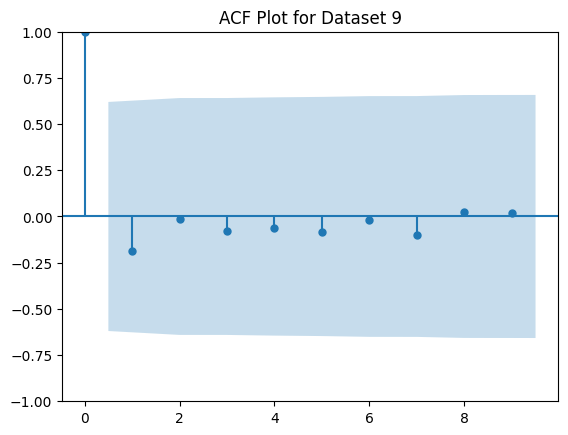

Seasonal periods detected: [2, None, 3, 3, None, 2, 5, None, None]


In [7]:
# Seasonality with ACF
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

seasonal_list = []  # 1 for seasonal, 0 for non-seasonal
seasonal_periods = []  # Record the seasonal period (m) for each dataset

for i, df_train in enumerate(df_train_list):
    # Calculate the maximum number of lags based on data length
    max_lags = min(50, len(df_train['sum_orig_bytes_log']) - 1)  # Ensure we don't exceed the data length
   
    # Calculate ACF Values
    acf_values = acf(df_train['sum_orig_bytes_log'], nlags=max_lags)

   
    # Threshold for significance (1.96/sqrt(N), where N is the number of observations)
    threshold = 1.96 / (len(df_train['sum_orig_bytes_log']) ** 0.5)
   
    # Identify significant lags
    significant_lags = [lag for lag, value in enumerate(acf_values) if abs(value) > threshold]
   
    # Determine if the dataset is seasonal
    seasonal = False
    seasonal_period = None
   
    for j in range(1, len(significant_lags)):
        # Calculate the gap between significant lags
        lag_gap = significant_lags[j] - significant_lags[j-1]
        if lag_gap > 1:  # Avoid immediate autocorrelations
            seasonal = True
            seasonal_period = lag_gap
            break
   
    # Record results
    if seasonal:
        print(f"The time series for dataset {i+1} shows evidence of seasonality with a period of {seasonal_period}.")
        seasonal_list.append(1)
        seasonal_periods.append(seasonal_period)
    else:
        print(f"The time series for dataset {i+1} does not show significant evidence of seasonality.")
        seasonal_list.append(0)
        seasonal_periods.append(None)  # No seasonality detected
   
    # Plot the ACF for visual purposes
    plt.figure(figsize=(10, 6))
    plot_acf(df_train['sum_orig_bytes_log'], lags=max_lags)
    plt.title(f"ACF Plot for Dataset {i+1}")
    plt.show()

# Print the seasonal periods found for reference
print("Seasonal periods detected:", seasonal_periods)

Determine p and q values using auto_arima() instead of graphical interpretation

In [8]:
from pmdarima import auto_arima

# Define lists for p, d, q
p_list = []
d_list = []
q_list = []

# Iterate over the datasets
for i, df_train in enumerate(df_train_list):
    # Get the seasonal period from the seasonal_list (if available)
    seasonal_period = seasonal_periods[i] if seasonal_list[i] == 1 else None  # Use the seasonal period found or None if no seasonality
   
    print(f"Fitting auto_arima for dataset {i+1}...")
   
    try:
        # Fit auto_arima to find optimal p, d, q values based on seasonality

        if seasonal_list[i] == 1:  # If seasonality is detected
            auto_model = auto_arima(df_train['sum_orig_bytes_log'],
                                    start_p=0, max_p=14,  # Range for p
                                    start_q=0, max_q=5,   # Range for q
                                    d=None,                # Let auto_arima determine d
                                    seasonal=True,         # Seasonality is detected
                                    m=seasonal_period,     # Use the seasonal period found
                                    trace=True,            # Output the process
                                    error_action='ignore',
                                    suppress_warnings=True,
                                    stepwise=True)
        else:  # If no seasonality is detected
            auto_model = auto_arima(df_train['sum_orig_bytes_log'],
                                    start_p=0, max_p=14,  # Range for p
                                    start_q=0, max_q=5,   # Range for q
                                    d=None,                # Let auto_arima determine d
                                    seasonal=False,        # No seasonality detected
                                    trace=True,            # Output the process
                                    error_action='ignore',
                                    suppress_warnings=True,
                                    stepwise=True)
       
        # Print the summary of the best model found
        print(f"Summary for Dataset {i+1}:")
        print(auto_model.summary())

        # Get the best values of p, d, and q
        p, d, q = auto_model.order

        p_list.append(p)
        d_list.append(d)
        q_list.append(q)

        print(f"Best p: {p}, d: {d}, q: {q} for Dataset {i+1}")
   
    except Exception as e:
        print(f"Error fitting auto_arima model for dataset {i+1}: {e}")
        print("Proceeding with fallback options.")


Fitting auto_arima for dataset 1...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=-110.536, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=-112.769, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=-113.585, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=-113.656, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=44.222, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept   : AIC=-111.253, Time=0.02 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=-108.771, Time=0.28 sec
 ARIMA(0,0,1)(0,0,2)[2] intercept   : AIC=-111.944, Time=0.07 sec
 ARIMA(0,0,1)(1,0,0)[2] intercept   : AIC=-113.589, Time=0.08 sec
 ARIMA(0,0,1)(1,0,2)[2] intercept   : AIC=-106.479, Time=0.26 sec
 ARIMA(0,0,0)(0,0,1)[2] intercept   : AIC=-115.544, Time=0.16 sec
 ARIMA(0,0,0)(0,0,2)[2] intercept   : AIC=-113.806, Time=0.20 sec
 ARIMA(0,0,0)(1,0,0)[2] intercept   : AIC=-115.428, Time=0.09 sec
 ARIMA(0,0,0)(1,0,2)[2] intercept   : AIC=inf, Time=0.26 sec
 ARI

Fit ARIMA Model based on p,d,q

In [9]:
'''from statsmodels.tsa.statespace.sarimax import SARIMAX

# List to store the fitted models
fitted_models = []

# Iterate through each dataset and corresponding p, d, q values
for i, (df_train, p, d, q, seasonal_period) in enumerate(zip(df_train_list, p_list, d_list, q_list, seasonal_periods)):
    print(f"Fitting ARIMA model for dataset {i+1} with parameters (p={p}, d={d}, q={q}) and seasonal_period={seasonal_period}")

    # Define exogenous variables (e.g., sum_resp_bytes, sum_resp_ip_bytes, connection_count, label_tactic_binary_agg)
    exog_variables = df_train[['sum_resp_bytes', 'sum_resp_ip_bytes', 'connection_count', 'label_tactic_binary_agg']]  # Using preprocessed 'label_tactic_binary_agg'
   
    try:
        if seasonal_period is not None:
            # Fit SARIMAX model with seasonality and exogenous variables
            model = SARIMAX(df_train['sum_orig_bytes_log'],
                            order=(p, d, q),
                            seasonal_order=(1, 1, 1, seasonal_period),  # Assuming seasonal_period from ACF analysis
                            exog=exog_variables)
        else:
            # Fit SARIMAX model without seasonality and with exogenous variables
            model = SARIMAX(df_train['sum_orig_bytes_log'],
                            order=(p, d, q),
                            seasonal_order=(0, 0, 0, 0),  # No seasonality
                            exog=exog_variables)

        # Fit the model
        model_fit = model.fit(disp=False)

        # Append the fitted model to the list
        fitted_models.append(model_fit)

        # Print the summary of the fitted model
        print(model_fit.summary())

    except Exception as e:
        print(f"Error fitting model for dataset {i+1}: {e}")
        print("Proceeding with fallback options.")

        # Fallback: Try fitting a simpler model (no exogenous variables)
        try:
            model = SARIMAX(df_train['sum_orig_bytes_log'],
                            order=(p, d, q),
                            seasonal_order=(0, 0, 0, 0),  # No seasonality
                            exog=None)  # No exogenous variables

            # Fit the fallback model
            model_fit = model.fit(disp=False)

            # Append the fitted model to the list
            fitted_models.append(model_fit)

            # Print the summary of the fallback model
            print(model_fit.summary())

        except Exception as e2:
            print(f"Error fitting fallback model for dataset {i+1}: {e2}")

# After the loop, 'fitted_models' will contain all the trained models
print(f"Total successfully fitted models: {len(fitted_models)}")'''

'from statsmodels.tsa.statespace.sarimax import SARIMAX\n\n# List to store the fitted models\nfitted_models = []\n\n# Iterate through each dataset and corresponding p, d, q values\nfor i, (df_train, p, d, q, seasonal_period) in enumerate(zip(df_train_list, p_list, d_list, q_list, seasonal_periods)):\n    print(f"Fitting ARIMA model for dataset {i+1} with parameters (p={p}, d={d}, q={q}) and seasonal_period={seasonal_period}")\n\n    # Define exogenous variables (e.g., sum_resp_bytes, sum_resp_ip_bytes, connection_count, label_tactic_binary_agg)\n    exog_variables = df_train[[\'sum_resp_bytes\', \'sum_resp_ip_bytes\', \'connection_count\', \'label_tactic_binary_agg\']]  # Using preprocessed \'label_tactic_binary_agg\'\n   \n    try:\n        if seasonal_period is not None:\n            # Fit SARIMAX model with seasonality and exogenous variables\n            model = SARIMAX(df_train[\'sum_orig_bytes_log\'],\n                            order=(p, d, q),\n                            seas

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

# Dictionary to store models and thresholds for each dataset
trained_models = {}

# Iterate through each dataset and corresponding parameters
for i, (df_train, p, d, q, seasonal_period) in enumerate(zip(df_train_list, p_list, d_list, q_list, seasonal_periods)):
    print(f"Fitting ARIMA model for dataset {i+1} with parameters (p={p}, d={d}, q={q}) and seasonal_period={seasonal_period}")

    # Define exogenous variables
    exog_train = df_train[['sum_resp_bytes', 'sum_resp_ip_bytes', 'connection_count', 'label_tactic_binary_agg']]

    try:
        # Fit SARIMAX model
        if seasonal_period is not None:
            model = SARIMAX(df_train['sum_orig_bytes_log'],
                            order=(p, d, q),
                            seasonal_order=(1, 1, 1, seasonal_period),
                            exog=exog_train)
        else:
            model = SARIMAX(df_train['sum_orig_bytes_log'],
                            order=(p, d, q),
                            seasonal_order=(0, 0, 0, 0),
                            exog=exog_train)

        # Fit the model
        model_fit = model.fit(disp=False)

        # Calculate residuals and thresholds for training set attacks
        residuals = model_fit.resid
        attack_residuals = residuals[df_train['label_tactic_binary_agg'] == 1]
        attack_residual_mean = np.mean(attack_residuals)
        attack_residual_std = np.std(attack_residuals)
        upper_threshold = attack_residual_mean + 3 * attack_residual_std
        lower_threshold = attack_residual_mean - 3 * attack_residual_std

        # Save the model and thresholds
        trained_models[i] = {
            "model": model_fit,
            "upper_threshold": upper_threshold,
            "lower_threshold": lower_threshold
        }

        print(f"Model fitted for dataset {i+1} with thresholds: {lower_threshold}, {upper_threshold}")

    except Exception as e:
        print(f"Error fitting model for dataset {i+1}: {e}")

Fitting ARIMA model for dataset 1 with parameters (p=0, d=0, q=0) and seasonal_period=2


/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model fitted for dataset 1 with thresholds: nan, nan
Fitting ARIMA model for dataset 2 with parameters (p=0, d=0, q=0) and seasonal_period=None
Model fitted for dataset 2 with thresholds: nan, nan
Fitting ARIMA model for dataset 3 with parameters (p=0, d=0, q=1) and seasonal_period=3


/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model fitted for dataset 3 with thresholds: nan, nan
Fitting ARIMA model for dataset 4 with parameters (p=1, d=0, q=0) and seasonal_period=3


/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model fitted for dataset 4 with thresholds: nan, nan
Fitting ARIMA model for dataset 5 with parameters (p=1, d=1, q=1) and seasonal_period=None


/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model fitted for dataset 5 with thresholds: nan, nan
Fitting ARIMA model for dataset 6 with parameters (p=0, d=0, q=1) and seasonal_period=2
Model fitted for dataset 6 with thresholds: nan, nan
Fitting ARIMA model for dataset 7 with parameters (p=0, d=0, q=0) and seasonal_period=5
Model fitted for dataset 7 with thresholds: nan, nan
Fitting ARIMA model for dataset 8 with parameters (p=0, d=0, q=0) and seasonal_period=None
Model fitted for dataset 8 with thresholds: -0.4207545979015106, 0.4207545978986673
Fitting ARIMA model for dataset 9 with parameters (p=0, d=0, q=0) and seasonal_period=None
Model fitted for dataset 9 with thresholds: -0.5933500615121551, 0.593350061512154


/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Diagnostic Tests

Visualizing dataset 1...


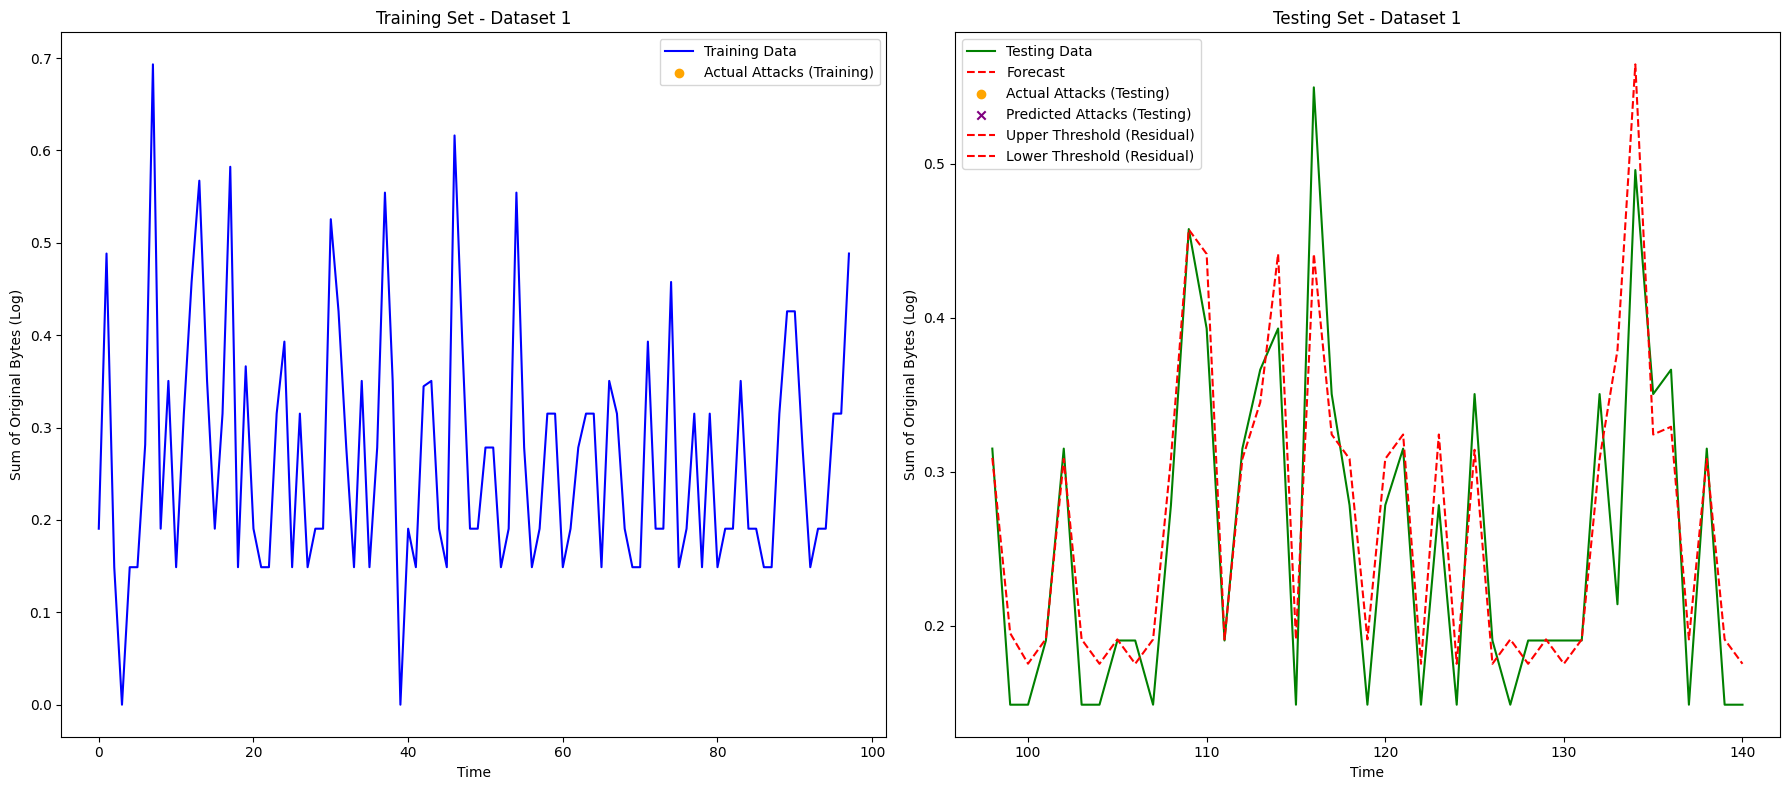

Visualizing dataset 2...


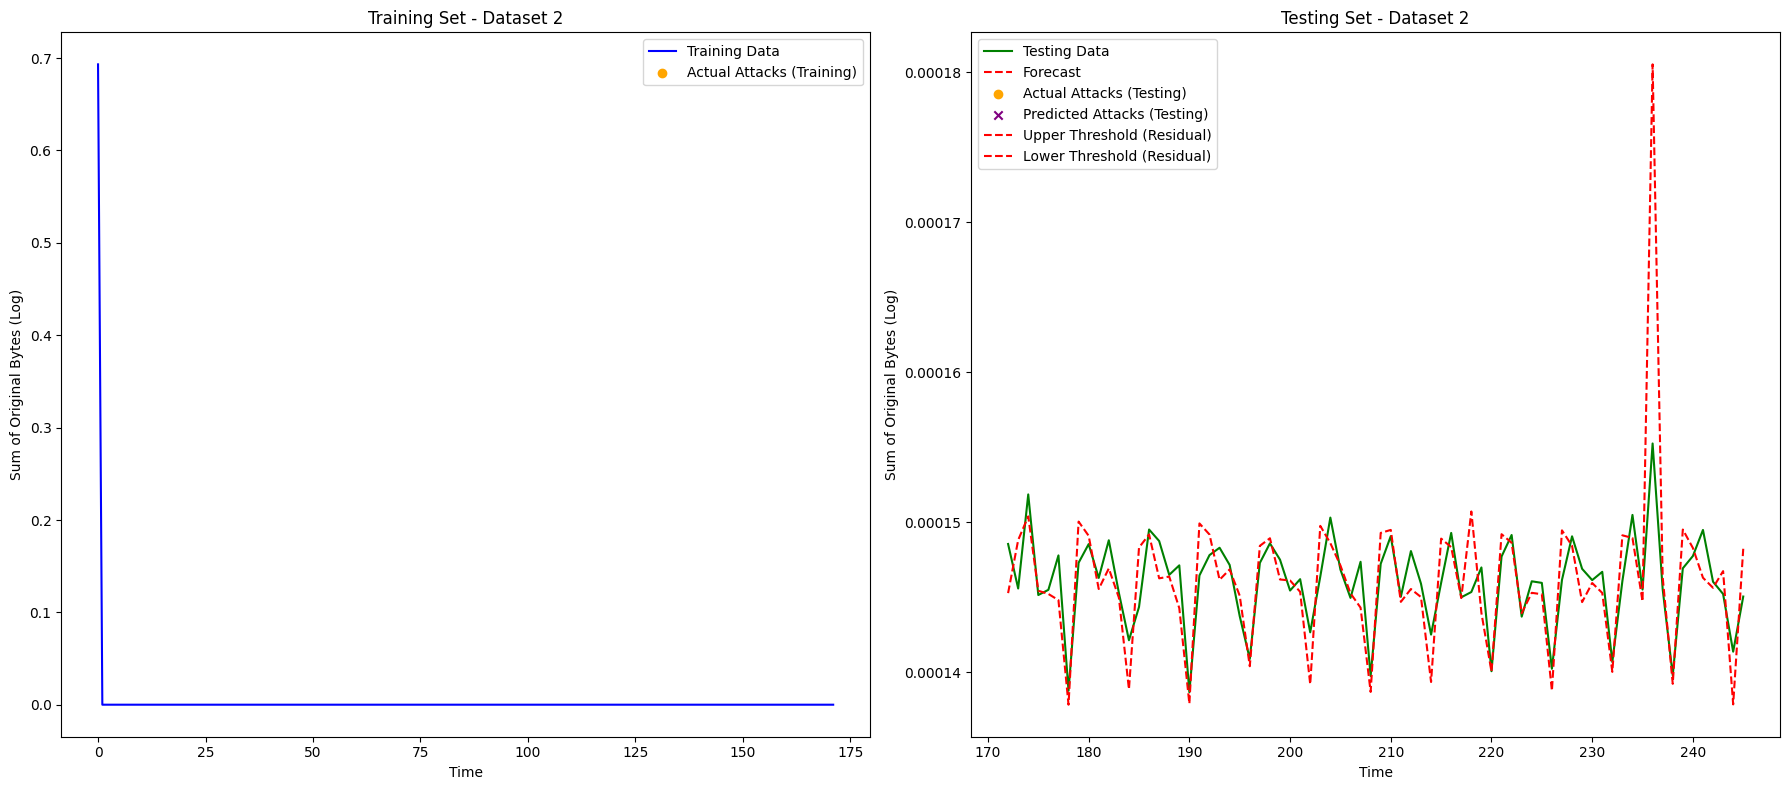

Visualizing dataset 3...


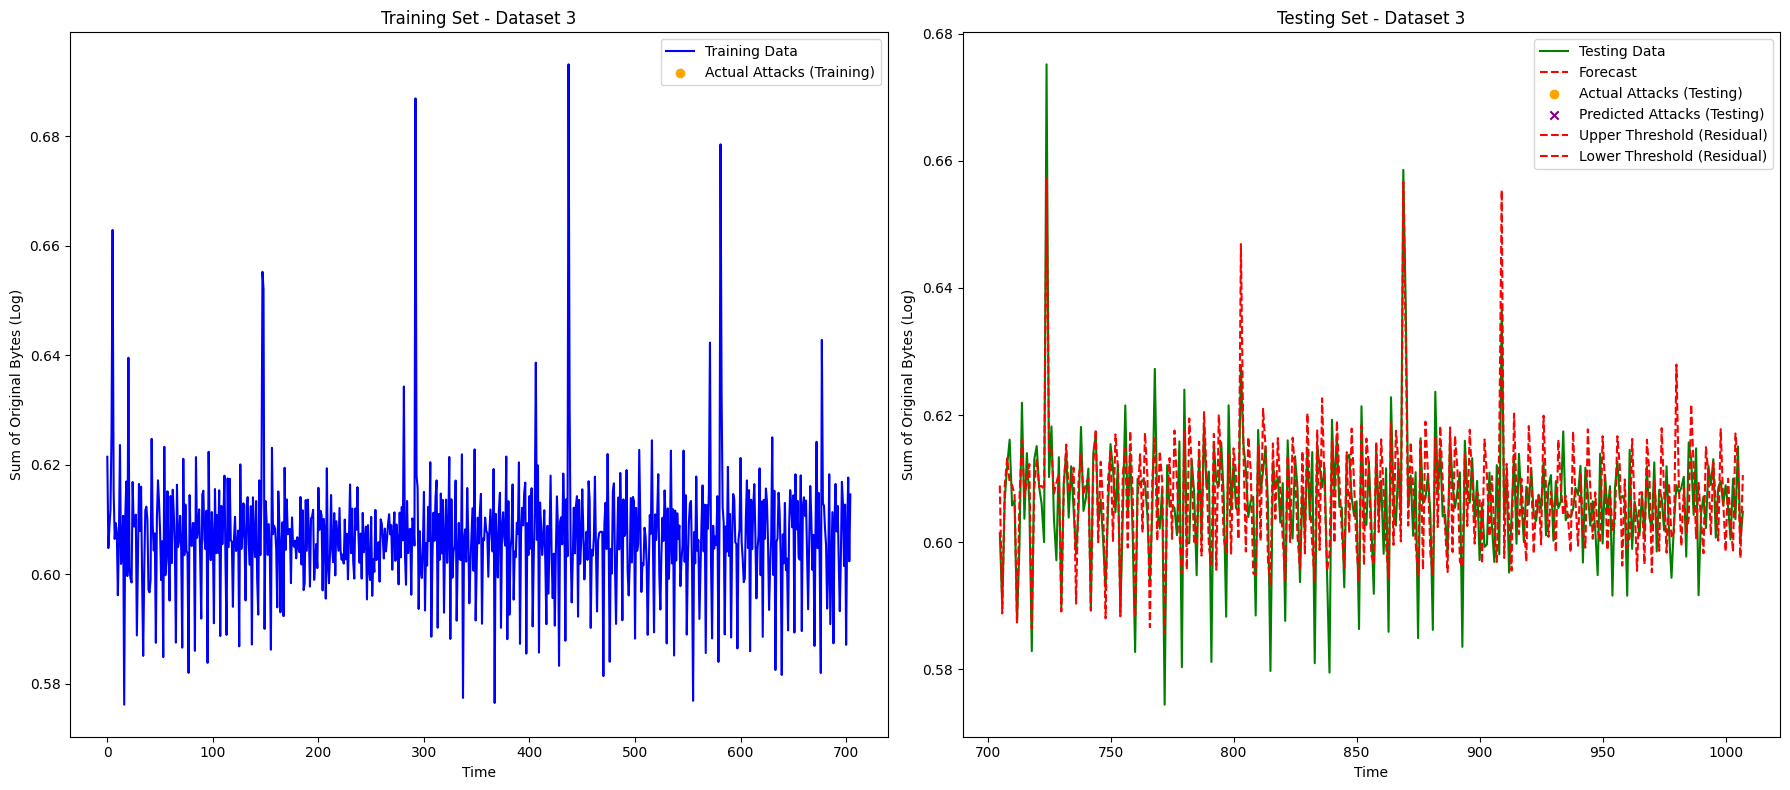

Visualizing dataset 4...


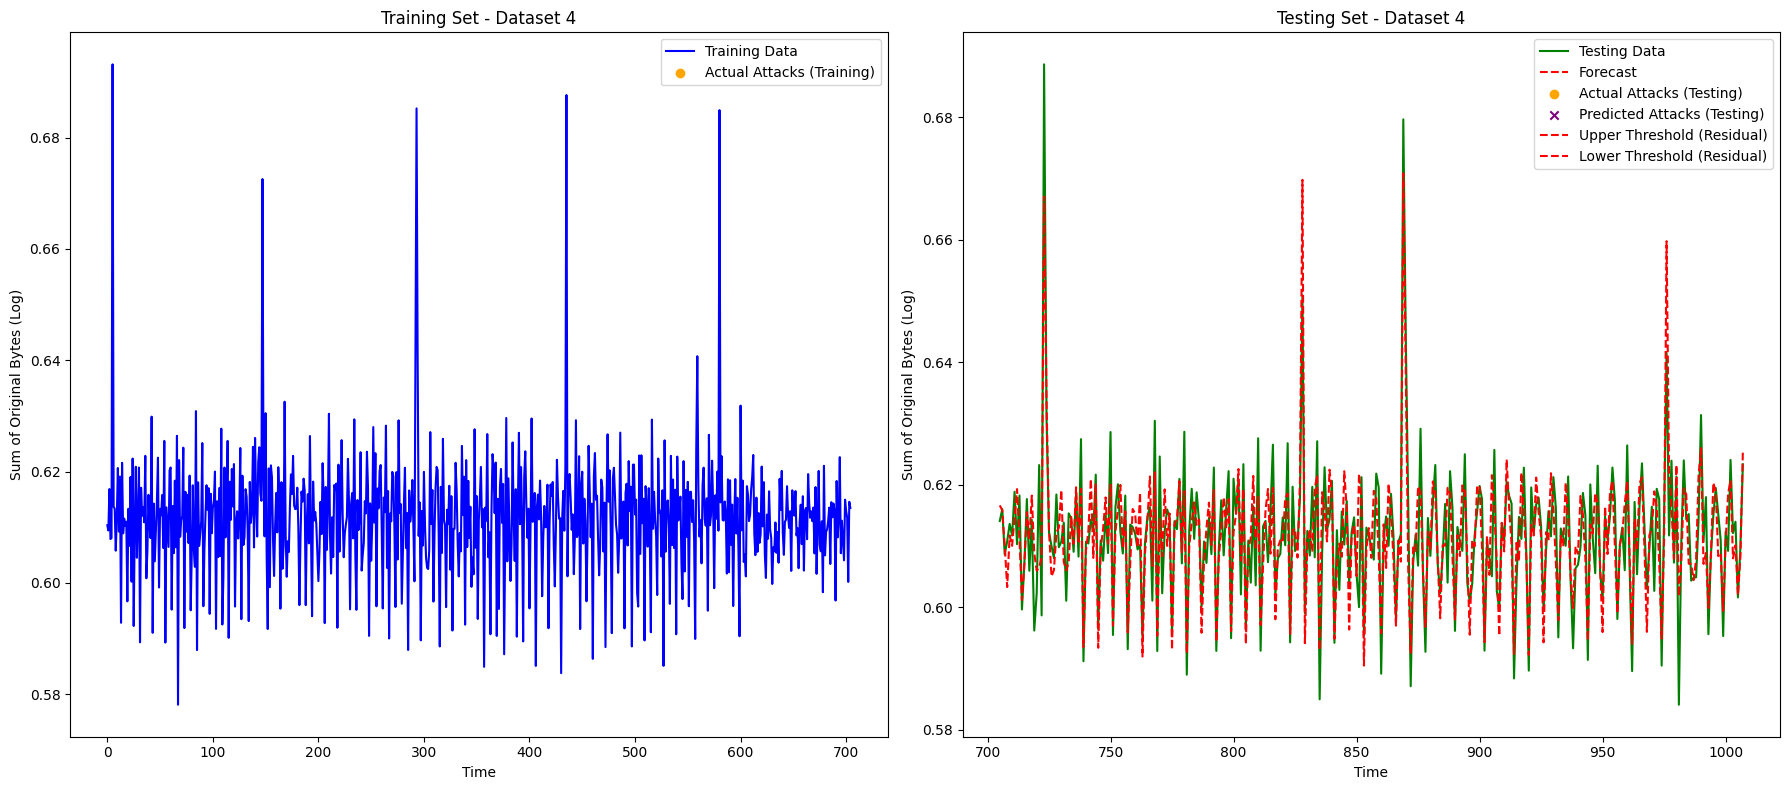

Visualizing dataset 5...


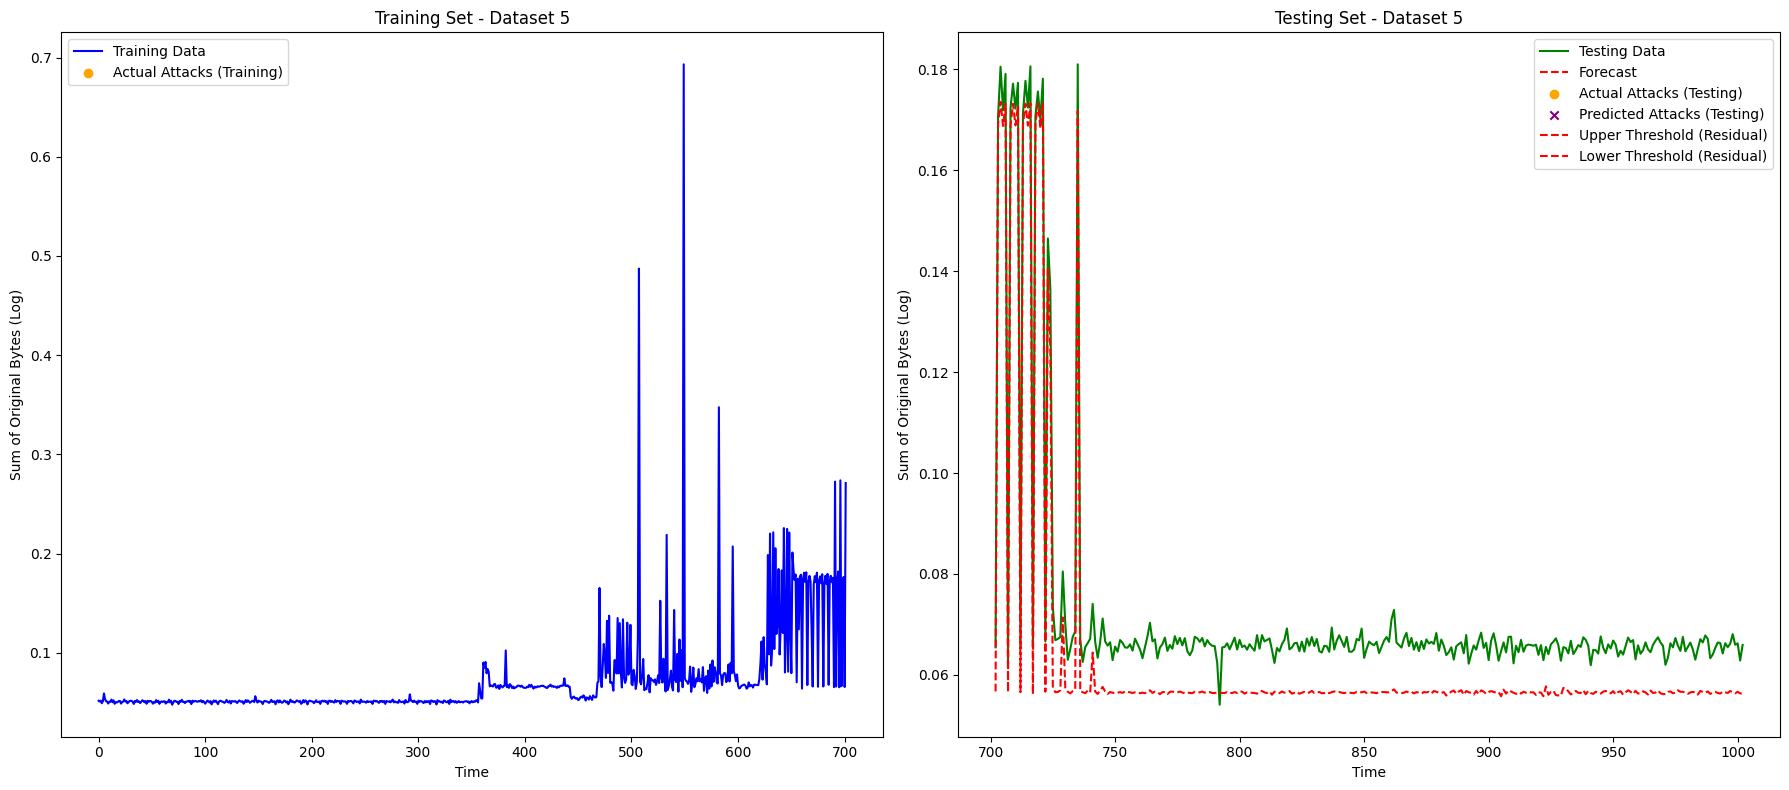

Visualizing dataset 6...


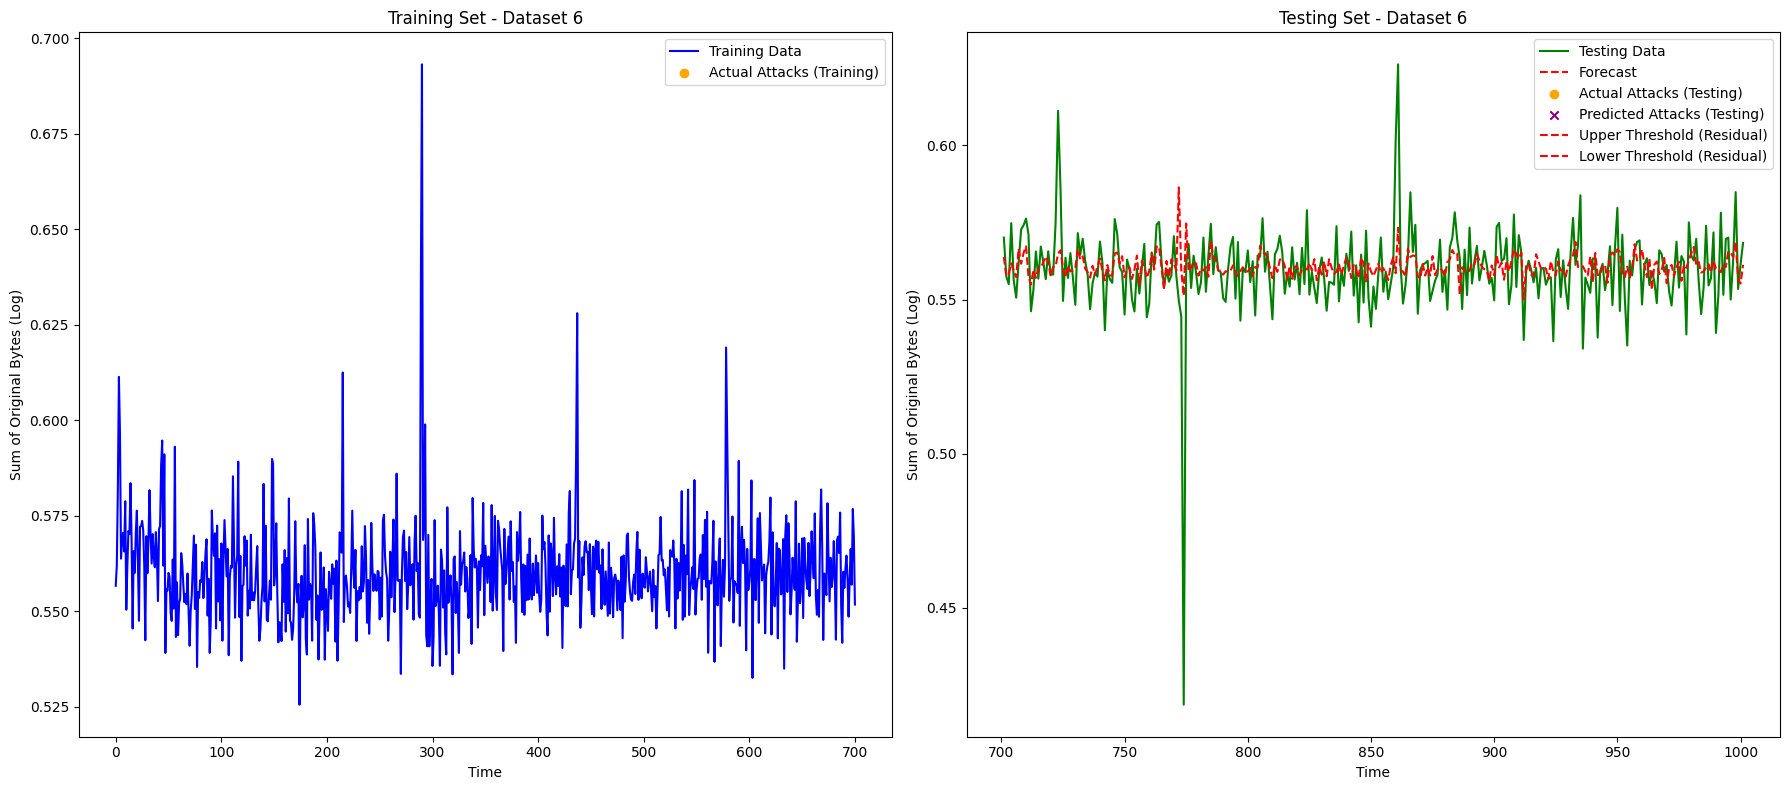

Visualizing dataset 7...


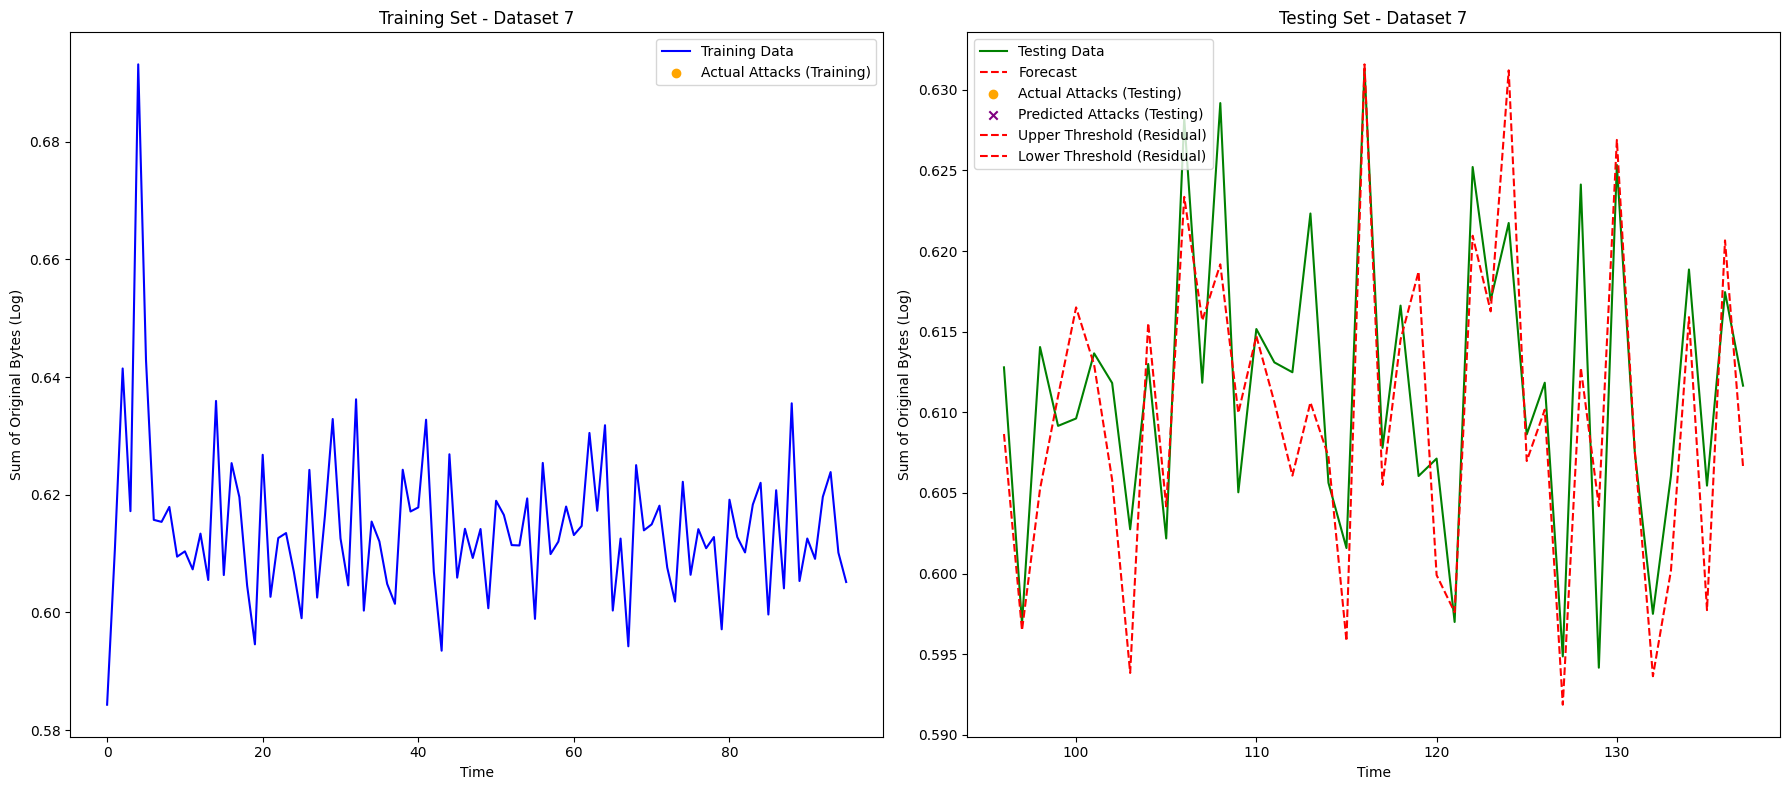

Visualizing dataset 8...


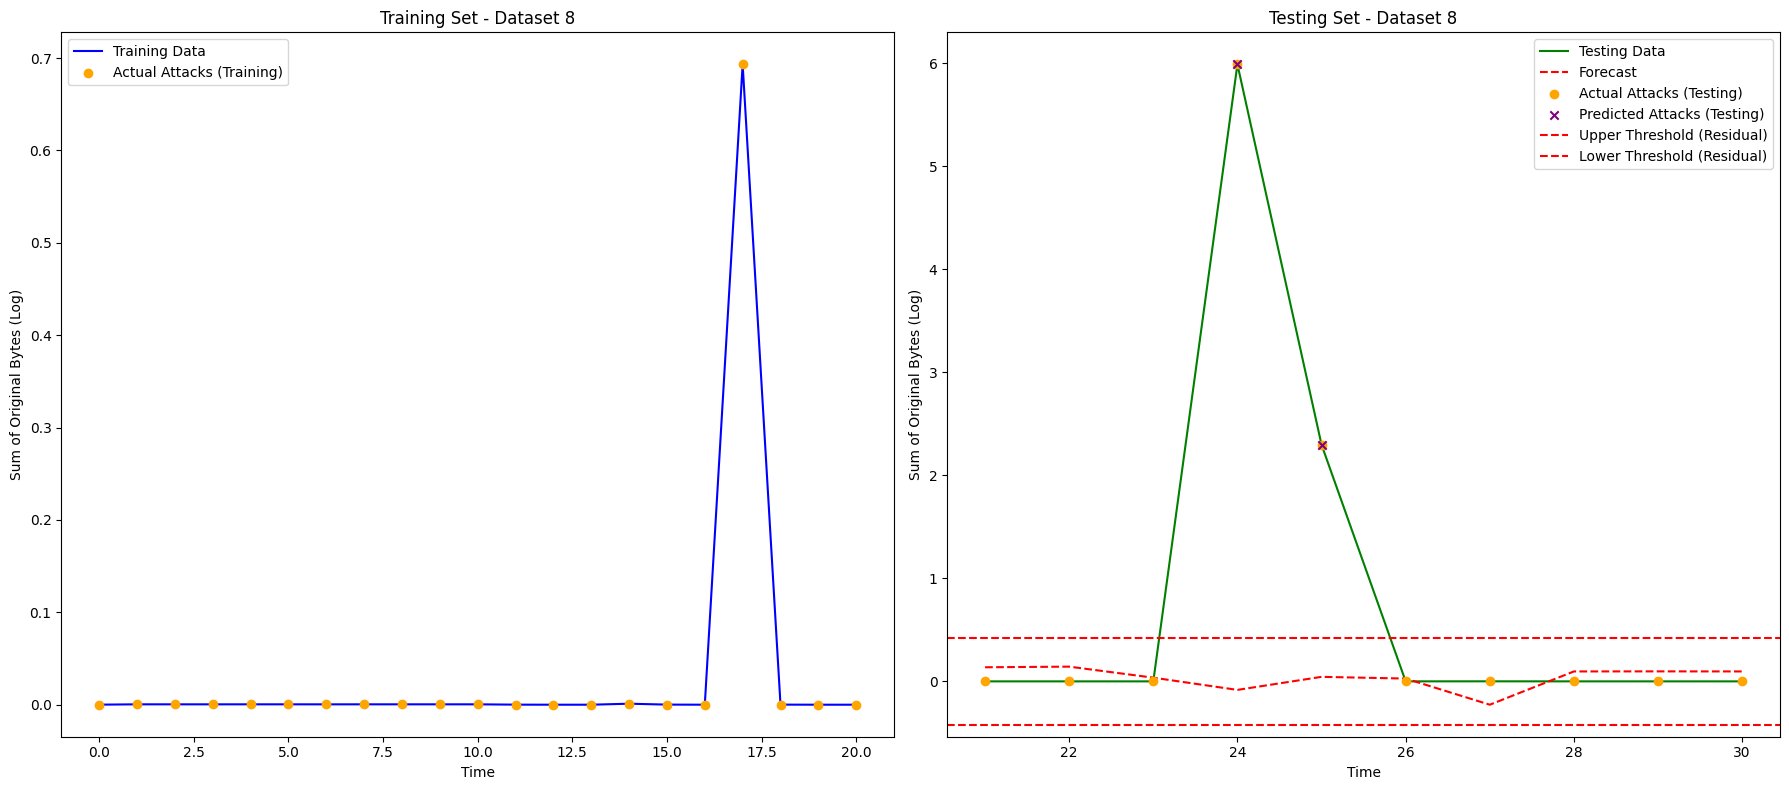

Visualizing dataset 9...


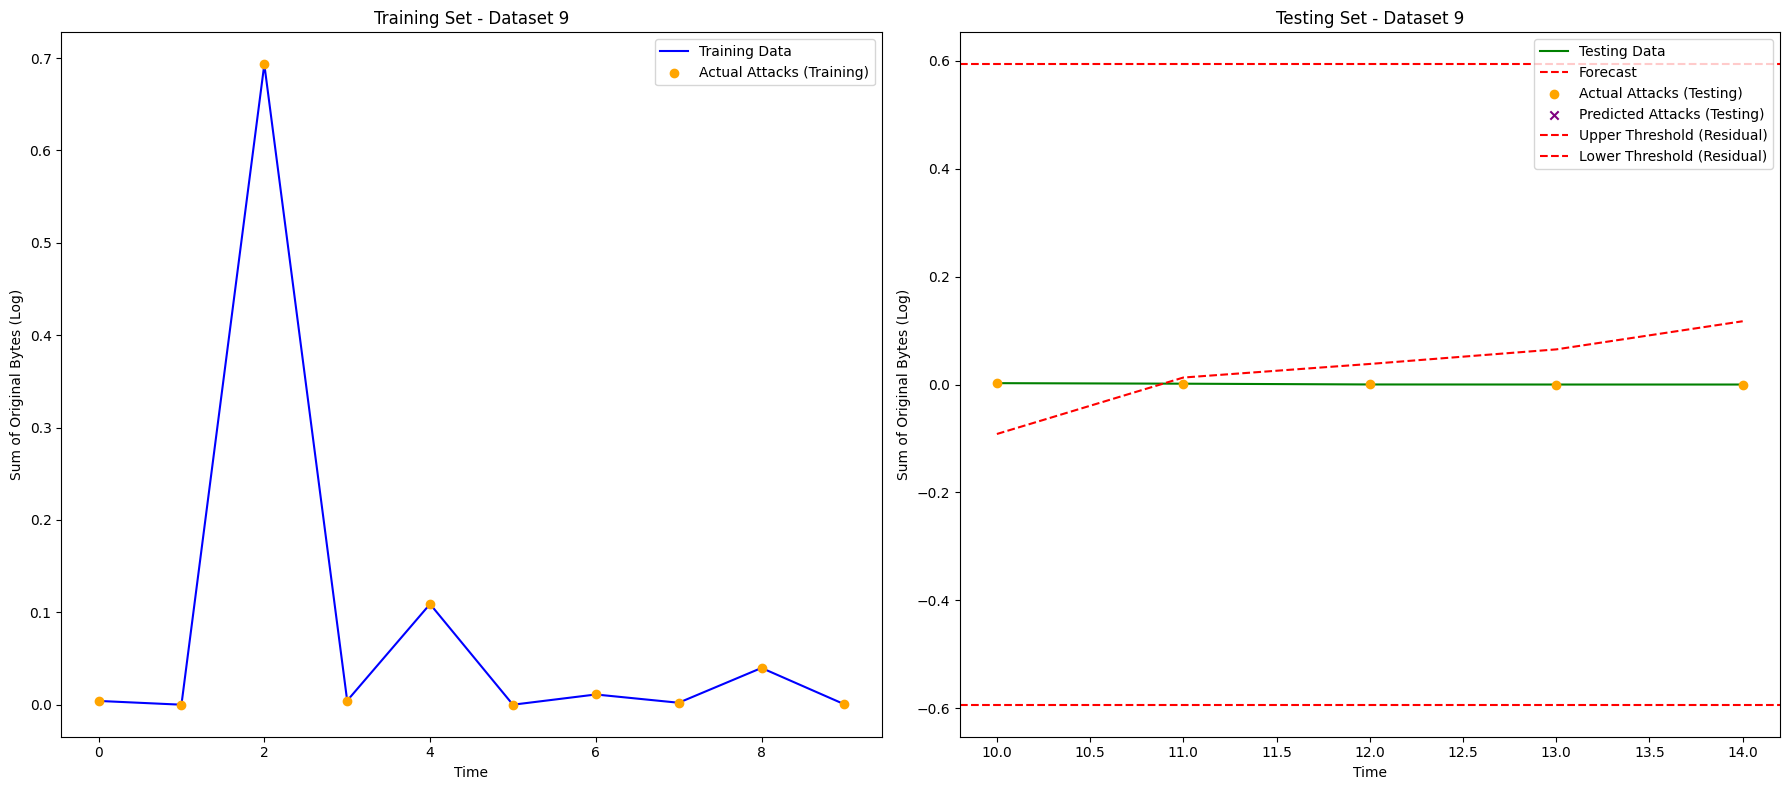

In [14]:
# Visualization: Compare training and testing data with attacks
for i, (df_train, df_test) in enumerate(zip(df_train_list, df_test_list)):
    print(f"Visualizing dataset {i+1}...")

    try:
        # Retrieve the model and thresholds
        model_fit = trained_models[i]["model"]
        upper_threshold = trained_models[i]["upper_threshold"]
        lower_threshold = trained_models[i]["lower_threshold"]

        # Forecast for the test set
        exog_test = df_test[['sum_resp_bytes', 'sum_resp_ip_bytes', 'connection_count', 'label_tactic_binary_agg']]
        forecast = model_fit.forecast(steps=len(df_test), exog=exog_test)

        # Calculate residuals for the test set
        test_residuals = df_test['sum_orig_bytes_log'] - forecast
        predicted_attack_labels = ((test_residuals > upper_threshold) | (test_residuals < lower_threshold)).astype(int)

        # Plotting: Training and Testing Data Side-by-Side
        plt.figure(figsize=(18, 8))

        # Training Data Plot
        plt.subplot(1, 2, 1)
        plt.plot(df_train.index, df_train['sum_orig_bytes_log'], label="Training Data", color="blue")
        attack_indices_train = df_train[df_train['label_tactic_binary_agg'] == 1].index
        plt.scatter(
            attack_indices_train,
            df_train['sum_orig_bytes_log'].loc[attack_indices_train],
            color="orange",
            label="Actual Attacks (Training)",
            zorder=5
        )
        plt.title(f"Training Set - Dataset {i+1}")
        plt.xlabel("Time")
        plt.ylabel("Sum of Original Bytes (Log)")
        plt.legend()

        # Testing Data Plot
        plt.subplot(1, 2, 2)
        plt.plot(df_test.index, df_test['sum_orig_bytes_log'], label="Testing Data", color="green")
        plt.plot(df_test.index, forecast, label="Forecast", color="red", linestyle="dashed")

        # Mark actual attacks in the testing data
        actual_attack_indices_test = df_test[df_test['label_tactic_binary_agg'] == 1].index
        plt.scatter(
            actual_attack_indices_test,
            df_test['sum_orig_bytes_log'].loc[actual_attack_indices_test],
            color="orange",
            label="Actual Attacks (Testing)",
            zorder=5
        )

        # Mark predicted attacks in the testing data
        predicted_attack_indices_test = df_test.index[predicted_attack_labels == 1]
        plt.scatter(
            predicted_attack_indices_test,
            df_test['sum_orig_bytes_log'].loc[predicted_attack_indices_test],
            color="purple",
            label="Predicted Attacks (Testing)",
            marker="x",
            zorder=5
        )

        # Add residual-based thresholds for visual reference
        plt.axhline(upper_threshold, color="red", linestyle="--", label="Upper Threshold (Residual)")
        plt.axhline(lower_threshold, color="red", linestyle="--", label="Lower Threshold (Residual)")

        plt.title(f"Testing Set - Dataset {i+1}")
        plt.xlabel("Time")
        plt.ylabel("Sum of Original Bytes (Log)")
        plt.legend()

        # Display the side-by-side plots
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error visualizing dataset {i+1}: {e}")